# Will a player get drafted ? A comparative analysis of Machine Learning model

### Table Of Content

1. Exploratory Data Analysis
2. Feature engineering to select the relevant subsets
3. Pre-processing
4. Evaluate the model
5. Hyperparameter fine tuning

# 1. Initial Data Analysis and Data Cleaning

We import the relevant package before starting our analysis.

In [654]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

Importing the data

In [713]:
df = pd.read_csv('/Users/gregorycrooks/Downloads/NFL.csv')

In [656]:
df.head()

,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
0,2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,Arizona Cardinals / 1st / 31st pick / 2009,31.004194,offense,backs_receivers,RB,Yes
1,2009,Will Davis\DaviWi99,22.0,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,Arizona Cardinals / 6th / 204th pick / 2009,33.510073,defense,defensive_lineman,DE,Yes
2,2009,Herman Johnson\JohnHe23,24.0,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,Arizona Cardinals / 5th / 167th pick / 2009,41.005821,offense,offensive_lineman,OG,Yes
3,2009,Rashad Johnson\JohnRa98,23.0,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,Arizona Cardinals / 3rd / 95th pick / 2009,28.312463,defense,defensive_back,FS,Yes
4,2009,Cody Brown\BrowCo96,22.0,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,Arizona Cardinals / 2nd / 63rd pick / 2009,31.327425,defense,line_backer,OLB,Yes


We find a total of 18 columns

In [714]:
len(df.columns)

18

Looking at the column types, we find:
1. <b> 11 Numerical columns </b>: Year, Age, Height, Weight, Sprint_40yd, Vertical_Jump, Bench_Press_Reps, Broad_Jump, Agility_3cone, Shuttle, BMI </br>

2. <b>7 Categorical columns </b>: Player, School, Drafted..tm.rnd.yr., Player_Type, Position_Type, Position, Drafted

In [658]:
df.dtypes

Year                     int64
Player                  object
Age                    float64
School                  object
Height                 float64
Weight                 float64
Sprint_40yd            float64
Vertical_Jump          float64
Bench_Press_Reps       float64
Broad_Jump             float64
Agility_3cone          float64
Shuttle                float64
Drafted..tm.rnd.yr.     object
BMI                    float64
Player_Type             object
Position_Type           object
Position                object
Drafted                 object
dtype: object

Check for duplicates:

In [715]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF


,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted


<b> Identifying Null values </b>

We find that some columns have a high percentage of null values. At the <b>highest</b>, 35% of the "Drafted..tm.rnd.yr." column has 35% null values. Similarly, we find that most of the columns for performances in drills tend to have a higher percentage of null values.

In [660]:
(df.isnull().sum()/(len(df)))*100

Year                    0.000000
Player                  0.000000
Age                    15.818234
School                  0.000000
Height                  0.000000
Weight                  0.000000
Sprint_40yd             5.004314
Vertical_Jump          20.046017
Bench_Press_Reps       26.028185
Broad_Jump             20.937590
Agility_3cone          35.001438
Shuttle                32.786885
Drafted..tm.rnd.yr.    35.174001
BMI                     0.000000
Player_Type             0.000000
Position_Type           0.000000
Position                0.000000
Drafted                 0.000000
dtype: float64

# 2. Data Cleaning

### Outlier Analysis

Identifying outliers is important to detect any value which is disproportionately high or small, to the extent which it would have to be removed from the data (5000 bench press reps for instance). We set our z-score threshold of 3 (values with + 3 or - 3 standard deviations from the mean for the variable).

Let's inspect each relevant variable:
1. Age seems to have a high number of upper bound outliers, with players drafted at 21+ players being drafted after 24. We find 2 lower bound outliers with 2 players drafted at 18 and 19
2. For each of drills, we tend to find outliers for players performing poorly. Inversely, outside of Bench press (8 upper bound outliers) we do not find many outliers outclassing the other players.

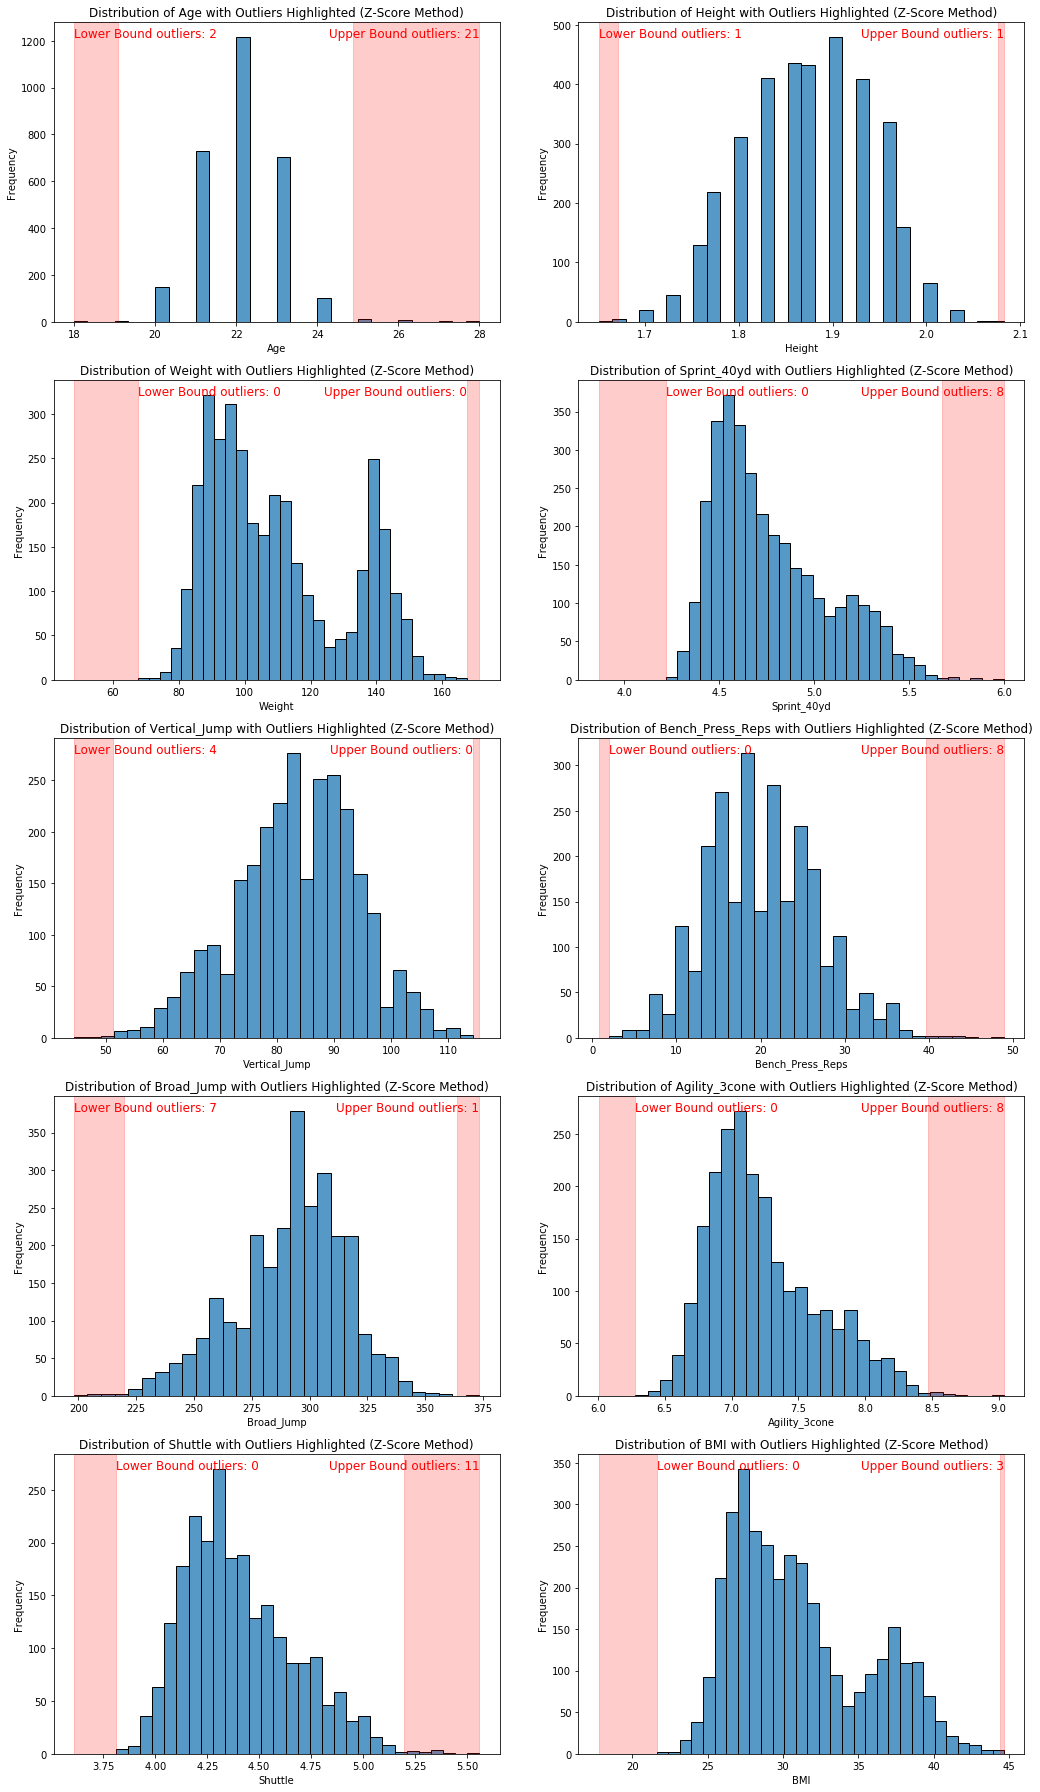

In [716]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have the necessary imports and dataframe already loaded.
num_cols = df.loc[:, df.columns != 'Year']
# Select numerical columns from the DataFrame
num_cols = num_cols.select_dtypes(include='number').columns

# Set up the figure for subplots
n_cols = 2  # Number of columns for subplots
n_rows = len(num_cols) // n_cols + int(len(num_cols) % n_cols > 0)

plt.figure(figsize=(15, 5 * n_rows))

# Loop through each numerical variable and create a subplot
for i, col in enumerate(num_cols):
    # Calculate the mean and standard deviation, ignoring NaN values
    mean = np.nanmean(df[col])
    std_dev = np.nanstd(df[col])
    
    # Calculate the lower and upper bound values based on z-scores of -3 and 3
    lower = mean - 3 * std_dev
    upper = mean + 3 * std_dev
    
    # Count outliers
    lower_outliers_count = (df[col] <= lower).sum()
    upper_outliers_count = (df[col] >= upper).sum()

    # Create subplot
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col].dropna(), kde=False, ax=ax, bins=30)  # Drop NaN values for plotting

    # Highlighting the outliers
    ax.axvspan(xmin=df[col].min(), xmax=lower, alpha=0.2, color='red')
    ax.axvspan(xmin=upper, xmax=df[col].max(), alpha=0.2, color='red')

    # Adding text annotations for outlier counts
    ax.text(df[col].min(), ax.get_ylim()[1] * 0.95, f'Lower Bound outliers: {lower_outliers_count}', color='red', fontsize=12)
    ax.text(df[col].max(), ax.get_ylim()[1] * 0.95, f'Upper Bound outliers: {upper_outliers_count}', color='red', fontsize=12, horizontalalignment='right')

    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {col} with Outliers Highlighted (Z-Score Method)')

plt.tight_layout()
plt.show()


### Formatting Errors

The <b> "Drafted..tm.rnd.yr." </b> contains information about the drafting team, round, pick rank, and year. Each value, if not null, has the following format: Arizona Cardinals / 1st / 31st pick / 2009. We clean this by separating this into 4 columns based on the "/" delimiter.

In [717]:
df[['Team','Round', "Pick", "Year"]] = df['Drafted..tm.rnd.yr.'].str.split('/',expand=True)

# Function to ensure only one space between words in each column
def normalize_spaces(s):
    if pd.isna(s):
        return s
    return ' '.join(s.split())

# Apply the function to each of the new columns
df['Team'] = df['Team'].apply(normalize_spaces)
df['Round'] = df['Round'].apply(normalize_spaces)
df['Pick'] = df['Pick'].apply(normalize_spaces)
df['Year'] = df['Year'].apply(normalize_spaces)

df = df.drop(columns=["Drafted..tm.rnd.yr."]) 

# Display the first few rows to verify the result
df[['Team', 'Round', 'Pick', 'Year']].head()

,Team,Round,Pick,Year
0,Arizona Cardinals,1st,31st pick,2009
1,Arizona Cardinals,6th,204th pick,2009
2,Arizona Cardinals,5th,167th pick,2009
3,Arizona Cardinals,3rd,95th pick,2009
4,Arizona Cardinals,2nd,63rd pick,2009


The <b> Round and Pick</b> columns are numerical and might provide relevant information. Let's remove all letters and convert them to numerical values:

In [718]:
import re
def omit_letters(s):
    if pd.isna(s):
        return s
    return re.sub('[^0-9]','', s)
df['Round'] = df['Round'].apply(omit_letters)
df['Pick'] = df['Pick'].apply(omit_letters)
df['Pick'] = df['Pick'].astype(float).astype('Int64')
df['Round'] = df['Round'].astype(float).astype('Int64')

The <b> "Player" </b> column values are occasionaly formatted with the player name followed by a backslash, and what looks to be a Username: "Beanie Wells\WellCh00". To resolve this, we remove the backslash symbol and any set of string after.

In [719]:
def normalize_spaces(s):
    if pd.isna(s):
        return s
    return ' '.join(s.split())

# Step 3: Apply the function to the 'Player' column to normalize spaces
df['Player'] = df['Player'].apply(normalize_spaces)

df['Player'] = df['Player'].str.split('\\').str[0]
df['Player'].head()

0      Beanie Wells
1        Will Davis
2    Herman Johnson
3    Rashad Johnson
4        Cody Brown
Name: Player, dtype: object

For the sake of better visualization, we have each first letter of the <b> Player Type</b> column in upper case format

In [720]:
df['Player_Type'] = df['Player_Type'].str.title()

df['Player_Type'].head()

0    Offense
1    Defense
2    Offense
3    Defense
4    Defense
Name: Player_Type, dtype: object

Likewise, values in the <b> "Position_Types" </b> column are oddly formatted. Let's replace them with improved formatting:

In [721]:
df["Position"].value_counts()

WR     506
CB     393
RB     320
OT     278
DT     255
DE     246
OLB    232
QB     194
TE     191
OG     188
ILB    148
SS     108
FS      98
C       89
P       63
S       56
FB      49
K       48
LS      13
DB       2
Name: Position, dtype: int64

In [722]:
# Define the mapping dictionary
position_mapping = {
    "backs_receivers": "Backs/Receivers",
    "defensive_back": "Defensive Back",
    "offensive_lineman": "Offensive Lineman",
    "defensive_lineman": "Defensive Lineman",
    "line_backer": "Linebacker",
    "kicking_specialist": "Kicking Specialist",
    "other_special": "Other Special"
}

# Apply the mapping to the Position_Type column
df["Position_Type"] = df["Position_Type"].replace(position_mapping)
df["Position_Type"].head()

0      Backs/Receivers
1    Defensive Lineman
2    Offensive Lineman
3       Defensive Back
4           Linebacker
Name: Position_Type, dtype: object

<b> The "Drafted column has NAs for players with aren't drafted </b>

In [723]:
df['Team'] = df['Team'].fillna("Not Drafted")


<b> Let's drop irrelevant columns:

Year is a duplicate of the already existing "Year" column

In [724]:
df = df.drop(columns=["Year"])

let's create an arbitrary column for players which aren't drafted

In [725]:
df['Round'] = df['Round'].fillna(8)
df['Round'] = df['Round'].astype(int)

### Dealing with Null Values

We found earlier in our analysis that the variables with the highest percentage of null values are numerical, specifically those related to athletic performance such as: <b> 'Sprint_40yd',
       'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone',
       'Shuttle' </b>

Looking at the relationship between numerical values, we notice that weight heavily correlates with a longer shuttle:

In [726]:
# Step 1: Identify highly correlated columns
correlation_matrix = df.corr().abs()

# We want to find pairs with a correlation of 70% or more
high_corr_pairs = correlation_matrix.stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] >= 0.7]
high_corr_pairs.head(7)

,level_0,level_1,0
14,Height,Weight,0.709092
25,Weight,Height,0.709092
27,Weight,Sprint_40yd,0.847610
30,Weight,Broad_Jump,0.710599
31,Weight,Agility_3cone,0.819166
32,Weight,Shuttle,0.797817
33,Weight,BMI,0.938884


Despite shuttle missing 35% of its values, we are able to create weight classes and find the mean of each other variable for all other columns. To illustrate this, let's create a graph highlighting the mean shuttle for the different weight classes.

As highlighted by the graph: the strong relationship between shuttle time and weight is represented. The bigger the weight class, the higher the mean shuttle. The relevancy of this with regards to missing values is replacing missing values by the mean of the strata. For instance, if a player is between 160 and 167kg, then we replace the null shuttle value with the 4.95 shuttle.

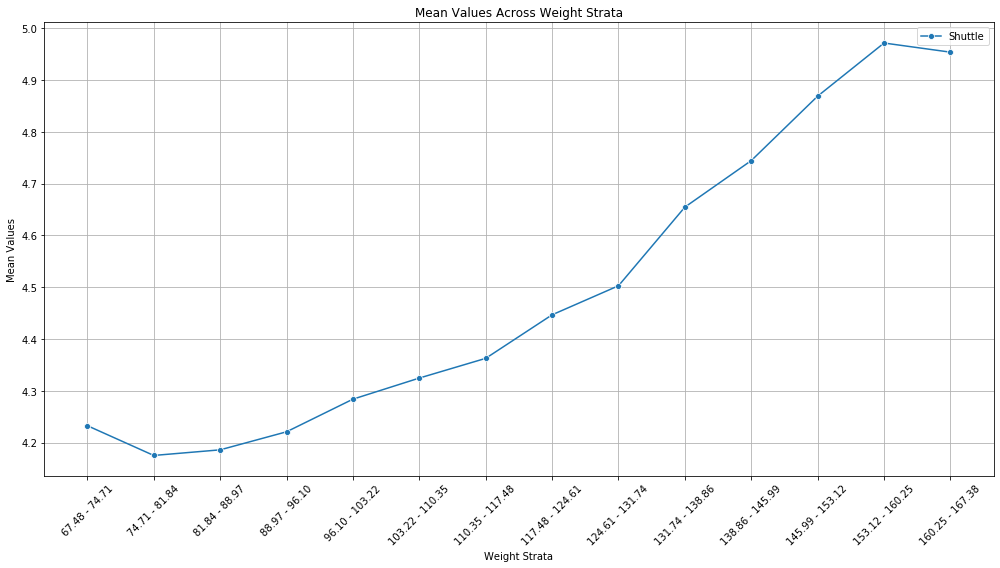

In [727]:
import seaborn as sns
plt.figure(figsize=(14, 8))
df['Weight_Strat'] = pd.cut(df['Weight'], bins=14)
grouped_means = df.groupby(['Weight_Strat']).mean().reset_index()
grouped_means['Weight_Strat'] = grouped_means['Weight_Strat'].apply(lambda x: f'{x.left:.2f} - {x.right:.2f}')
grouped_means["Weight_Strat"] = grouped_means["Weight_Strat"].astype(object)
sns.lineplot(data=grouped_means, x='Weight_Strat', y='Shuttle', label='Shuttle', marker='o')

# Formatting the plot
plt.xticks(rotation=45)
plt.xlabel('Weight Strata')
plt.ylabel('Mean Values')
plt.title('Mean Values Across Weight Strata')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

For better accuracy, let's first look, for each of the numerical variables, the other numerical variable with the highest correlation:

In [728]:
import pandas as pd

# Assuming 'df' is your DataFrame with numerical variables only
numerical_columns = ['Weight', 'Sprint_40yd', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height']

# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Find the variable with the highest correlation for each variable
highest_correlation = {}
for col in correlation_matrix.columns:
    # Exclude self-correlation by setting it to NaN
    correlation_matrix.loc[col, col] = np.nan
    # Find the maximum correlation value and its corresponding variable
    max_corr_value = correlation_matrix[col].max()
    max_corr_var = correlation_matrix[col].idxmax()
    highest_correlation[col] = (max_corr_var, max_corr_value)

# Convert the result to a DataFrame for better visualization
highest_correlation_df = pd.DataFrame(highest_correlation, index=['Most Correlated Variable', 'Correlation Coefficient']).T

highest_correlation_df

,Most Correlated Variable,Correlation Coefficient
Weight,BMI,0.938884
Sprint_40yd,Weight,0.84761
Broad_Jump,Vertical_Jump,0.828687
Agility_3cone,Shuttle,0.880689
Vertical_Jump,Broad_Jump,0.828687
Shuttle,Agility_3cone,0.880689
BMI,Weight,0.938884
Height,Weight,0.709092


Let's illustrate the correlations:

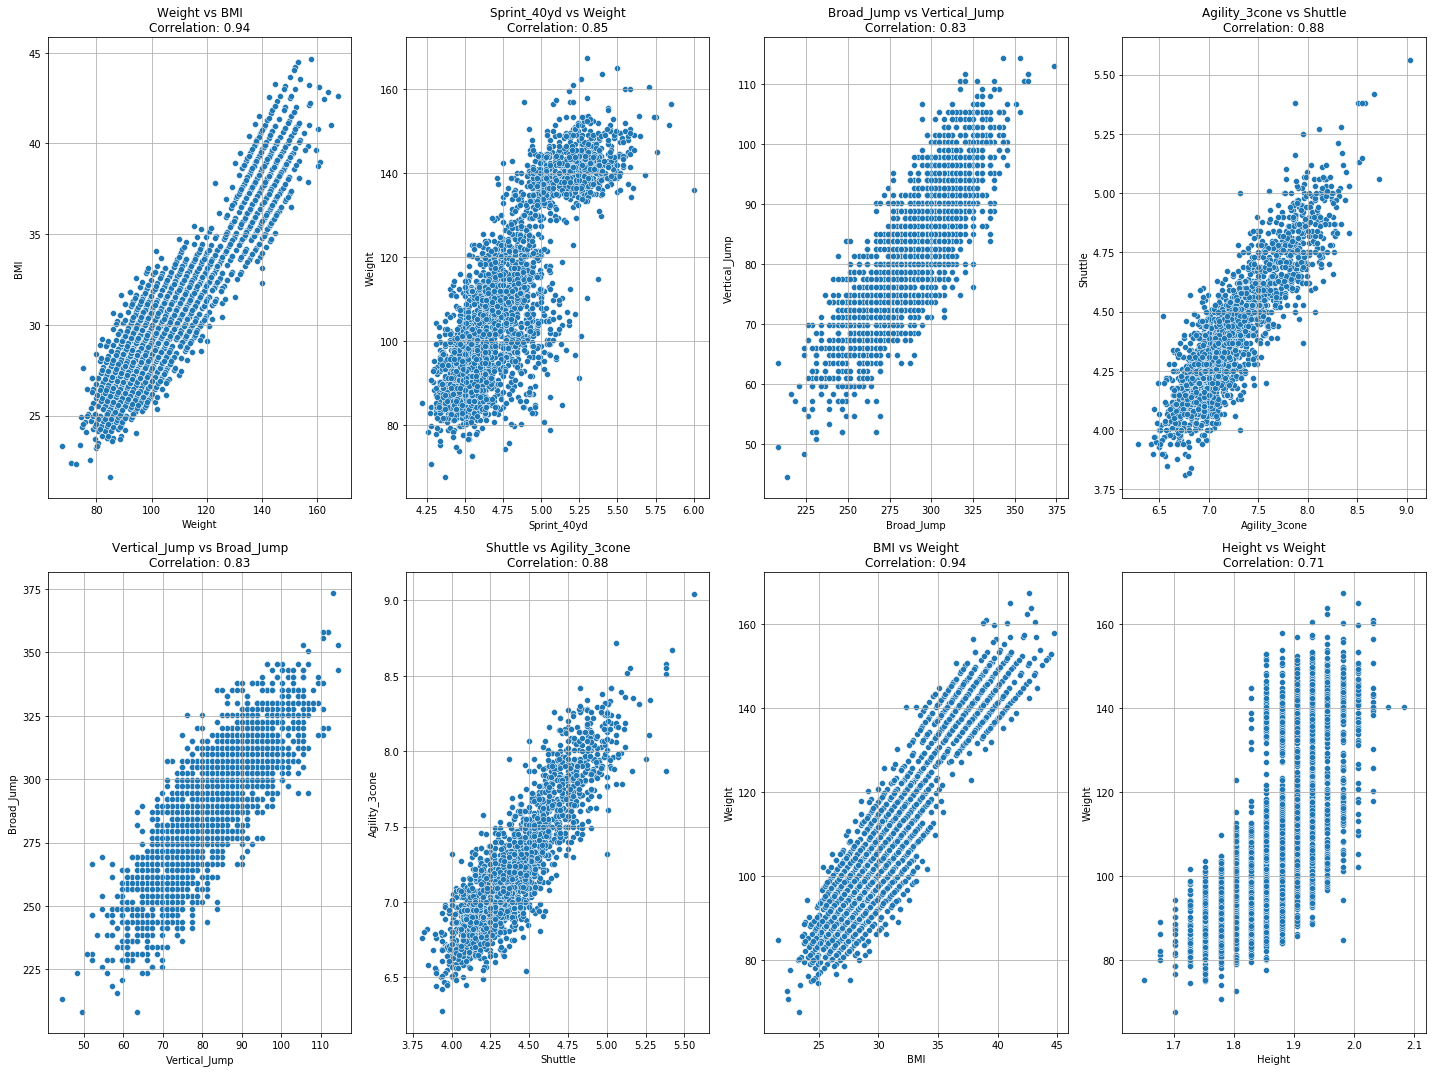

In [729]:
# Create a grid of plots (4 plots per row)
num_vars = len(highest_correlation_df)
fig, axes = plt.subplots((num_vars + 3) // 4, 4, figsize=(20, 15))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plotting each pair
for i, (var, row) in enumerate(highest_correlation_df.iterrows()):
    most_corr_var = row['Most Correlated Variable']
    sns.scatterplot(data=df, x=var, y=most_corr_var, ax=axes[i])
    axes[i].set_title(f'{var} vs {most_corr_var}\nCorrelation: {row["Correlation Coefficient"]:.2f}')
    axes[i].grid(True)

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We find a similar pattern for each correlated variable. For each of the numerical variables, <b> we find the most highly correlated variable </b>, create strats dividing the variable into subgroups, and subsequently find the mean of correlated variable for each subgroup.

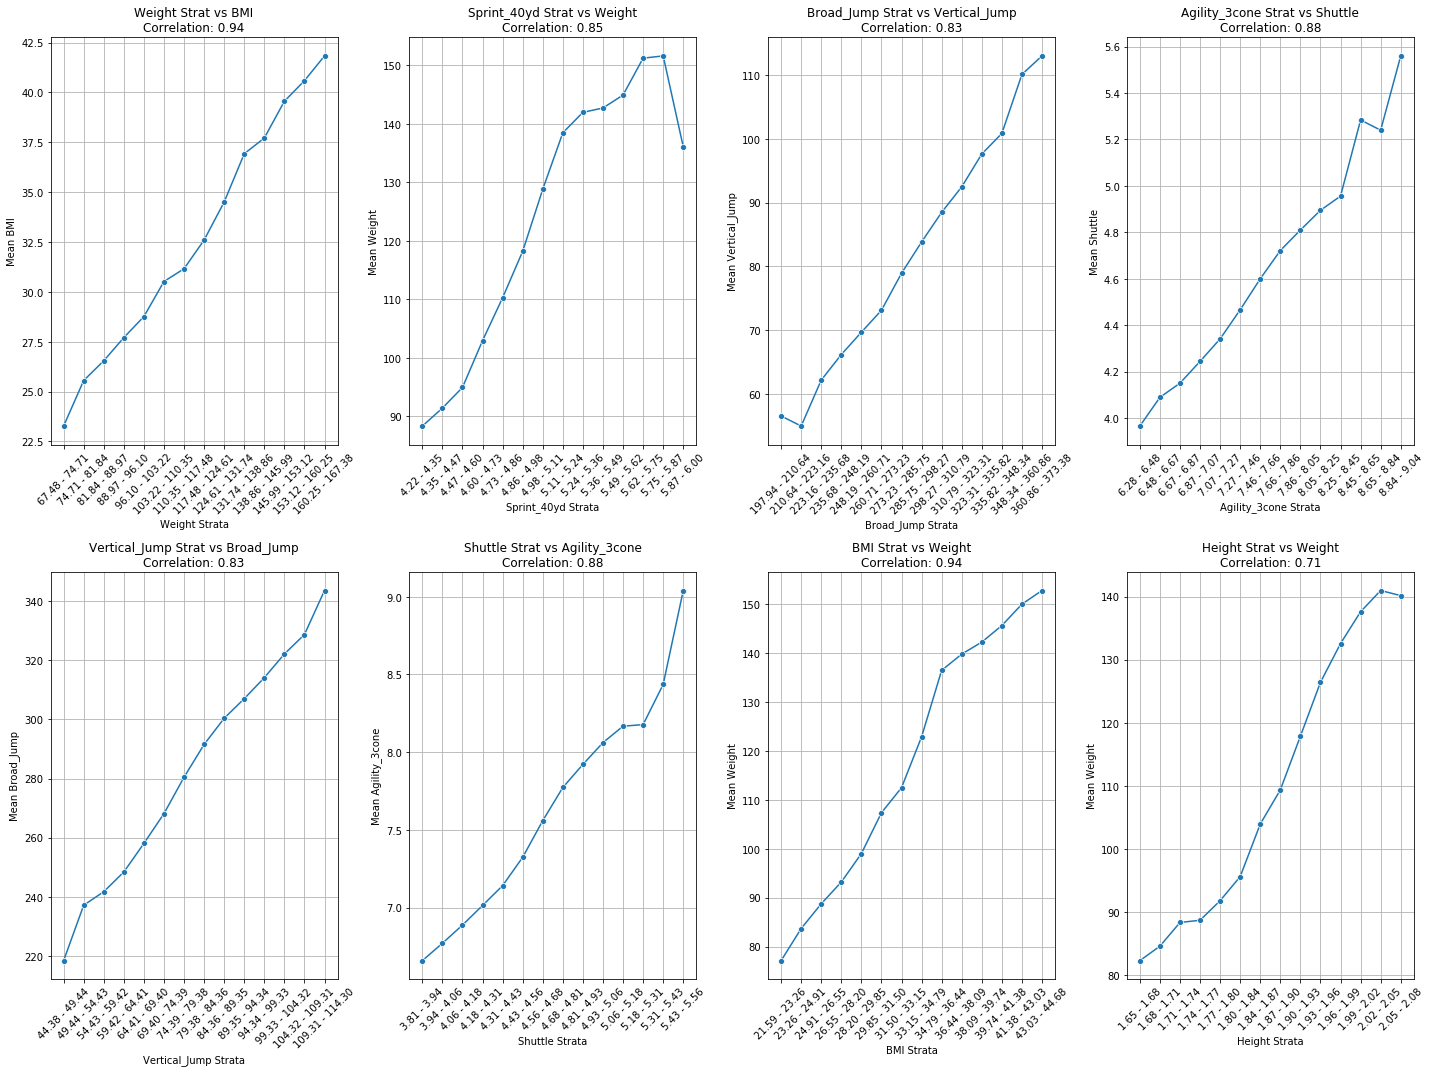

In [730]:
# Convert the result to a DataFrame
highest_correlation_df = pd.DataFrame(highest_correlation, index=['Most Correlated Variable', 'Correlation Coefficient']).T

# Create a grid of plots (4 plots per row)
num_vars = len(highest_correlation_df)
fig, axes = plt.subplots((num_vars + 3) // 4, 4, figsize=(20, 15))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plotting each pair with strata for the x-axis variable
for i, (var, row) in enumerate(highest_correlation_df.iterrows()):
    most_corr_var = row['Most Correlated Variable']
    
    # Create strata for the x-axis variable
    df[f'{var}_Strat'] = pd.cut(df[var], bins=14)
    
    # Group by the strata and calculate the mean for the y-axis variable
    grouped_means = df.groupby([f'{var}_Strat'])[most_corr_var].mean().reset_index()
    
    # Convert strata to string format for plotting
    grouped_means[f'{var}_Strat'] = grouped_means[f'{var}_Strat'].apply(lambda x: f'{x.left:.2f} - {x.right:.2f}')
    grouped_means[f'{var}_Strat'] = grouped_means[f'{var}_Strat'].astype(object)
    
    # Line plot
    sns.lineplot(data=grouped_means, x=f'{var}_Strat', y=most_corr_var, ax=axes[i], marker='o')
    axes[i].set_title(f'{var} Strat vs {most_corr_var}\nCorrelation: {row["Correlation Coefficient"]:.2f}')
    axes[i].set_xlabel(f'{var} Strata')
    axes[i].set_ylabel(f'Mean {most_corr_var}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Given this, we use multivariate <b> Linear Regression model</b> to replace null values. For each missing value within q numerical variable column, we find all the numerical variables which: 
1. Are non-null 
2. Have a strong correlation (positive or negative)

We then use model to predict the missing value, and replace it with the model prediction

In [731]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

#Remove strats
df = df[[x for x in df if not x.endswith('_Strat')]]    
# Step 1: Identify highly correlated columns
correlation_matrix = df.corr().abs()

# We want to find pairs with a correlation of 70% or more
high_corr_pairs = correlation_matrix.stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] >= 0.7]

# Step 2: Function to predict and fill missing values using multiple explanatory variables
def fill_missing_values_multivariable(df, col_to_fill, explanatory_vars):
    # One hot encoding categorical variables to include in the predictor
    df = pd.get_dummies(df, columns=['Drafted', 'Position_Type'])
    # Separate the data into those with and without missing values
    non_null_df = df[df[col_to_fill].notnull()]
    null_df = df[df[col_to_fill].isnull()]
    
    # If there's no missing value, return the column as is
    if null_df.empty:
        return df[col_to_fill]
    
    # Ensure that we only use explanatory variables that are not null
    explanatory_vars = [var for var in explanatory_vars if var in df.columns and df[var].isnull().sum() == 0]
    
    # Train a linear regression model on non-null data
    X_train = non_null_df[explanatory_vars]
    y_train = non_null_df[col_to_fill]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict the missing values
    X_predict = null_df[explanatory_vars]
    y_predict = model.predict(X_predict)
    
    # Fill the missing values with the predictions
    df.loc[df[col_to_fill].isnull(), col_to_fill] = y_predict
    
    return df[col_to_fill]

# Step 3: Apply the model to fill missing values for each column
columns_to_predict = ['Shuttle', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', "Age"]

for col in columns_to_predict:
    explanatory_vars = [c for c in columns_to_predict if c != col]
    df[col] = fill_missing_values_multivariable(df, col, explanatory_vars)

# Display the DataFrame after filling missing values
df

,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Player_Type,Position_Type,Position,Drafted,Team,Round,Pick
0,Beanie Wells,20.000000,Ohio St.,1.8542,106.594207,4.380000,85.090000,25.00000,325.120000,7.083763,4.358944,31.004194,Offense,Backs/Receivers,RB,Yes,Arizona Cardinals,1,31
1,Will Davis,22.000000,Illinois,1.8796,118.387609,4.840000,83.820000,27.00000,292.100000,7.380000,4.450000,33.510073,Defense,Defensive Lineman,DE,Yes,Arizona Cardinals,6,204
2,Herman Johnson,24.000000,LSU,2.0066,165.107623,5.500000,63.893789,21.00000,243.153925,8.122168,4.949310,41.005821,Offense,Offensive Lineman,OG,Yes,Arizona Cardinals,5,167
3,Rashad Johnson,23.000000,Alabama,1.8034,92.079251,4.490000,93.980000,15.00000,304.800000,7.090000,4.230000,28.312463,Defense,Defensive Back,FS,Yes,Arizona Cardinals,3,95
4,Cody Brown,22.000000,Connecticut,1.8796,110.676538,4.760000,92.710000,26.00000,304.800000,7.100000,4.400000,31.327425,Defense,Linebacker,OLB,Yes,Arizona Cardinals,2,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3472,Xavier Crawford,21.848136,Central Michigan,1.8034,84.821773,4.480000,95.250000,11.00000,313.882728,6.832931,4.137911,26.080939,Defense,Defensive Back,CB,No,Not Drafted,8,<NA>
3473,Jordan Brown,21.794021,South Dakota St.,1.8288,91.172066,4.510000,100.330000,13.00000,325.120000,6.908023,4.199939,27.260221,Defense,Defensive Back,CB,No,Not Drafted,8,<NA>
3474,Corey Ballentine,21.661302,Washburn,1.8034,88.904105,4.470000,100.330000,15.00000,342.900000,6.820000,4.140000,27.336171,Defense,Defensive Back,CB,No,Not Drafted,8,<NA>
3475,Ugo Amadi,21.799892,Oregon,1.7526,90.264882,4.510000,82.550000,18.00000,292.100000,7.210000,4.190000,29.386861,Defense,Defensive Back,S,No,Not Drafted,8,<NA>


In [733]:
import pandas as pd

# Assuming df_encoded and correlation_matrix are already defined

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df, columns=['Drafted', 'Position_Type'])

# Calculate the correlation matrix (without taking absolute values)
correlation_matrix = df_encoded.corr()

# Filter for correlations involving "Position_" columns
position_correlations = correlation_matrix.filter(like="Position_").unstack().reset_index()

# Sort the correlations by their absolute values (to rank by strength, regardless of sign)
position_correlations['abs_corr'] = position_correlations[0].abs()
position_correlations = position_correlations.sort_values(by='abs_corr', ascending=False).drop(columns=['abs_corr'])

# Rename columns for clarity
position_correlations.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Filter to keep only those rows with correlation between -0.99 and -0.4, or 0.4 and 0.99
position_correlations = position_correlations[
    ((position_correlations['Correlation'] >= 0.4) & 
     (position_correlations['Correlation'] < 0.99)) |
    ((position_correlations['Correlation'] <= -0.4) & 
     (position_correlations['Correlation'] > -0.99))
]

# Filter to keep only those that include "Position_" in either level
position_correlations = position_correlations[
    position_correlations['Variable 1'].str.contains('Position_') | 
    position_correlations['Variable 2'].str.contains('Position_')
]

# Display the resulting
position_correlations

,Variable 1,Variable 2,Correlation
108,Position_Type_Offensive Lineman,Sprint_40yd,0.700681
107,Position_Type_Offensive Lineman,Weight,0.683461
112,Position_Type_Offensive Lineman,Agility_3cone,0.675687
113,Position_Type_Offensive Lineman,Shuttle,0.654678
114,Position_Type_Offensive Lineman,BMI,0.621241
111,Position_Type_Offensive Lineman,Broad_Jump,-0.606457
109,Position_Type_Offensive Lineman,Vertical_Jump,-0.561810
106,Position_Type_Offensive Lineman,Height,0.480302
23,Position_Type_Defensive Back,Weight,-0.460901
51,Position_Type_Defensive Lineman,BMI,0.438539


In [678]:
df.corr()

,Age,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Round,Pick
Age,1.000000,0.116834,0.090806,0.145327,-0.118047,0.039001,-0.146605,0.081568,0.087591,0.060927,0.221249,0.228461
Height,0.116834,1.000000,0.709092,0.606750,-0.454812,0.335423,-0.432315,0.540096,0.568185,0.426552,-0.084763,-0.073868
Weight,0.090806,0.709092,1.000000,0.852783,-0.666533,0.711691,-0.728248,0.860258,0.845660,0.938884,-0.088743,-0.053302
Sprint_40yd,0.145327,0.606750,0.852783,1.000000,-0.784743,0.472142,-0.842411,0.832678,0.804601,0.794770,0.104274,0.063216
Vertical_Jump,-0.118047,-0.454812,-0.666533,-0.784743,1.000000,-0.312603,0.845366,-0.692616,-0.687363,-0.629679,-0.130523,-0.096147
Bench_Press_Reps,0.039001,0.335423,0.711691,0.472142,-0.312603,1.000000,-0.403547,0.557947,0.532904,0.757698,-0.165976,-0.073675
Broad_Jump,-0.146605,-0.432315,-0.728248,-0.842411,0.845366,-0.403547,1.000000,-0.753309,-0.738479,-0.719324,-0.132005,-0.105506
Agility_3cone,0.081568,0.540096,0.860258,0.832678,-0.692616,0.557947,-0.753309,1.000000,0.905774,0.836786,0.040510,0.029611
Shuttle,0.087591,0.568185,0.845660,0.804601,-0.687363,0.532904,-0.738479,0.905774,1.000000,0.804825,0.038444,0.027521
BMI,0.060927,0.426552,0.938884,0.794770,-0.629679,0.757698,-0.719324,0.836786,0.804825,1.000000,-0.071390,-0.031011


In [734]:
import pandas as pd

# Assuming 'df' is your DataFrame

# List of the columns to analyze
columns_to_analyze = ['Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle']

# Group by 'Round' and calculate the mean for each of the selected columns
round_means = df.groupby('Round')[columns_to_analyze].mean()

# Calculate the overall average across the specified columns for each Round
round_means['Average'] = round_means.mean(axis=1)

# Sort the rounds by the overall average and get the top 10
top_10_rounds = round_means.sort_values(by='Average', ascending=False)

# Display the top 10 rounds and their corresponding stats
print("Rounds with the Best average stats:")
top_10_rounds

Rounds with the Best average stats:


,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Average
Round,,,,,,,
1,4.722837,85.367144,21.373391,296.175891,7.176508,4.371860,69.864605
2,4.737194,84.976154,20.779203,294.642138,7.207073,4.382696,69.454076
4,4.718413,84.661824,20.043190,294.180713,7.185401,4.368232,69.192962
3,4.748959,83.894917,20.520337,293.404540,7.226594,4.387843,69.030531
5,4.757675,83.003030,19.847749,290.315082,7.207900,4.378859,68.251716
6,4.752357,82.905371,19.479647,290.755905,7.207140,4.385650,68.247678
7,4.797399,82.658279,20.250081,288.347535,7.234162,4.406266,67.948954
8,4.805997,81.679971,18.203421,287.784386,7.233298,4.398998,67.351012


In [735]:
import pandas as pd

# Assuming 'df' is your DataFrame

# List of the columns to analyze
columns_to_analyze = ['Sprint_40yd', 'Agility_3cone', 'Shuttle']

# Group by 'Round' and 'Position' and calculate the mean for each of the selected columns
round_position_means = df.groupby(['Round', 'Position'])[columns_to_analyze].mean()

# Calculate the overall average across the specified columns for each group
round_position_means['Average'] = round_position_means.mean(axis=1)

# Find the position with the highest average stats in each round
best_position_by_round = round_position_means.groupby('Round')['Average'].idxmax()

# Extract the rows corresponding to the best positions for each round
best_position_stats = round_position_means.loc[best_position_by_round]

# Display the results
print("Position with the best average agility stats by round:")
best_position_stats

Position with the best average agility stats by round:


,,Sprint_40yd,Agility_3cone,Shuttle,Average
Round,Position,,,,
1,OG,5.234458,7.733691,4.694318,5.887489
2,OT,5.215698,7.817743,4.750050,5.927830
3,OG,5.280455,7.816568,4.752187,5.949736
4,OG,5.276316,7.864805,4.764166,5.968429
5,OT,5.228216,7.871522,4.796453,5.965397
6,OG,5.271765,7.853543,4.817516,5.980941
7,OG,5.312500,7.810122,4.746765,5.956463
8,OG,5.349697,7.946651,4.868598,6.054982


In [736]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Filter the DataFrame for players drafted in Round 1
round_1_df = df[df['Round'] == 1]

# Count the number of occurrences of each position in Round 1
position_counts = round_1_df['Position'].value_counts()

# Calculate the proportion of each position in Round 1
total_round_1 = len(round_1_df)
position_proportions = position_counts / total_round_1

# Find the position with the highest proportion
highest_proportion_position = position_proportions.idxmax()
highest_proportion_value = position_proportions.max()

# Display the result
print(f"Position with the highest proportion in Round 1: {highest_proportion_position}")
print(f"Proportion: {highest_proportion_value:.2%}")


Position with the highest proportion in Round 1: OT
Proportion: 12.77%


In [738]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Count the number of players per position
position_counts = df['Position'].value_counts()

# Filter to include only positions with 20 or more players
positions_with_20_or_more = position_counts[position_counts >= 20].index

# Filter the DataFrame to include only those positions
df_filtered = df[df['Position'].isin(positions_with_20_or_more)]

# Columns to analyze for lowest and highest averages
columns_to_minimize = ['Sprint_40yd', 'Agility_3cone', 'Shuttle']
columns_to_maximize = ['Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump']

# Group by 'Position_Type' and calculate the mean for each of the selected columns within the filtered DataFrame
position_means_min = df_filtered.groupby('Position')[columns_to_minimize].mean()
position_means_max = df_filtered.groupby('Position')[columns_to_maximize].mean()

# Calculate the overall mean for minimizing and maximizing columns
position_means_min['Average_Min'] = position_means_min.mean(axis=1)
position_means_max['Average_Max'] = position_means_max.mean(axis=1)

# Find the position with the lowest average for minimizing columns
position_with_lowest_avg = position_means_min['Average_Min'].idxmin()
lowest_avg_value = position_means_min.loc[position_with_lowest_avg, 'Average_Min']

# Find the position with the highest average for maximizing columns
position_with_highest_avg = position_means_max['Average_Max'].idxmax()
highest_avg_value = position_means_max.loc[position_with_highest_avg, 'Average_Max']

# Calculate the mean of the lowest and highest averages
mean_of_avgs = (lowest_avg_value + highest_avg_value) / 2

# Display the results
print(f"Position with the lowest average for {columns_to_minimize}: {position_with_lowest_avg}, Average: {lowest_avg_value:.2f}")
print(f"Position with the highest average for {columns_to_maximize}: {position_with_highest_avg}, Average: {highest_avg_value:.2f}")
print(f"Mean of the lowest and highest averages: {mean_of_avgs:.2f}")


Position with the lowest average for ['Sprint_40yd', 'Agility_3cone', 'Shuttle']: CB, Average: 5.18
Position with the highest average for ['Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump']: S, Average: 138.64
Mean of the lowest and highest averages: 71.91


In [739]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Columns to minimize and maximize
columns_to_minimize = ['Sprint_40yd', 'Agility_3cone', 'Shuttle']
columns_to_maximize = ['Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump']

# Group by 'Position_Type' and calculate the mean for each of the selected columns
position_means_min = df.groupby('Position')[columns_to_minimize].mean()
position_means_max = df.groupby('Position')[columns_to_maximize].mean()

# Normalize the data to bring everything to the same scale (0-1)
position_means_min_normalized = (position_means_min - position_means_min.min()) / (position_means_min.max() - position_means_min.min())
position_means_max_normalized = (position_means_max - position_means_max.min()) / (position_means_max.max() - position_means_max.min())

# Since we want to minimize the columns in position_means_min, we subtract them from 1 to reverse the scale
position_means_min_normalized = 1 - position_means_min_normalized

# Combine the normalized scores into a single DataFrame
combined_scores = position_means_min_normalized.join(position_means_max_normalized)

# Calculate a composite score by averaging the normalized values
combined_scores['Composite_Score'] = combined_scores.mean(axis=1)

# Identify the position with the highest composite score
best_position = combined_scores['Composite_Score'].idxmax()
best_position_value = combined_scores.loc[best_position, 'Composite_Score']

# Display the results
print(f"The position with the best composite score (highest max metrics and lowest min metrics) is: {best_position}")
print(f"Composite Score: {best_position_value:.2f}")
print("Detailed Scores:")
print(combined_scores.loc[best_position])


The position with the best composite score (highest max metrics and lowest min metrics) is: CB
Composite Score: 0.82
Detailed Scores:
Sprint_40yd         1.000000
Agility_3cone       0.916513
Shuttle             1.000000
Vertical_Jump       0.966725
Bench_Press_Reps    0.144890
Broad_Jump          0.892731
Composite_Score     0.820143
Name: CB, dtype: float64


In [740]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Columns to minimize and maximize
columns_to_minimize = ['Sprint_40yd', 'Agility_3cone', 'Shuttle']
columns_to_maximize = ['Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump']

# Normalize the data to bring everything to the same scale (0-1) for each player
df_min_normalized = (df[columns_to_minimize] - df[columns_to_minimize].min()) / (df[columns_to_minimize].max() - df[columns_to_minimize].min())
df_max_normalized = (df[columns_to_maximize] - df[columns_to_maximize].min()) / (df[columns_to_maximize].max() - df[columns_to_maximize].min())

# Since we want to minimize the columns in columns_to_minimize, we subtract them from 1 to reverse the scale
df_min_normalized = 1 - df_min_normalized

# Combine the normalized scores into a single DataFrame
combined_scores = df_min_normalized.join(df_max_normalized)

# Calculate a composite score by averaging the normalized values for each player
df['Composite_Score'] = combined_scores.mean(axis=1)

# Group by 'Player' to calculate the composite score for each player
player_composite_scores = df.groupby('Player')['Composite_Score'].mean().reset_index()

# Merge the composite score back into the original DataFrame
df = df.merge(player_composite_scores, on='Player', suffixes=('', '_Player'))

# Display the first few rows of the updated DataFrame to check the new column
df

,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,...,BMI,Player_Type,Position_Type,Position,Drafted,Team,Round,Pick,Composite_Score,Composite_Score_Player
0,Beanie Wells,20.000000,Ohio St.,1.8542,106.594207,4.380000,85.090000,25.00000,325.120000,7.083763,...,31.004194,Offense,Backs/Receivers,RB,Yes,Arizona Cardinals,1,31,0.683505,0.683505
1,Will Davis,22.000000,Illinois,1.8796,118.387609,4.840000,83.820000,27.00000,292.100000,7.380000,...,33.510073,Defense,Defensive Lineman,DE,Yes,Arizona Cardinals,6,204,0.586534,0.650991
2,Will Davis,22.000000,Utah St.,1.8034,84.368181,4.510000,90.170000,16.00000,322.580000,6.520000,...,25.941468,Defense,Defensive Back,CB,Yes,Miami Dolphins,3,93,0.715447,0.650991
3,Herman Johnson,24.000000,LSU,2.0066,165.107623,5.500000,63.893789,21.00000,243.153925,8.122168,...,41.005821,Offense,Offensive Lineman,OG,Yes,Arizona Cardinals,5,167,0.316998,0.316998
4,Rashad Johnson,23.000000,Alabama,1.8034,92.079251,4.490000,93.980000,15.00000,304.800000,7.090000,...,28.312463,Defense,Defensive Back,FS,Yes,Arizona Cardinals,3,95,0.651536,0.651536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3472,Xavier Crawford,21.848136,Central Michigan,1.8034,84.821773,4.480000,95.250000,11.00000,313.882728,6.832931,...,26.080939,Defense,Defensive Back,CB,No,Not Drafted,8,<NA>,0.674250,0.674250
3473,Jordan Brown,21.794021,South Dakota St.,1.8288,91.172066,4.510000,100.330000,13.00000,325.120000,6.908023,...,27.260221,Defense,Defensive Back,CB,No,Not Drafted,8,<NA>,0.690899,0.690899
3474,Corey Ballentine,21.661302,Washburn,1.8034,88.904105,4.470000,100.330000,15.00000,342.900000,6.820000,...,27.336171,Defense,Defensive Back,CB,No,Not Drafted,8,<NA>,0.729668,0.729668
3475,Ugo Amadi,21.799892,Oregon,1.7526,90.264882,4.510000,82.550000,18.00000,292.100000,7.210000,...,29.386861,Defense,Defensive Back,S,No,Not Drafted,8,<NA>,0.617515,0.617515


In [685]:
df.columns

Index(['Player', 'Age', 'School', 'Height', 'Weight', 'Sprint_40yd',
       'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone',
       'Shuttle', 'BMI', 'Player_Type', 'Position_Type', 'Position', 'Drafted',
       'Team', 'Round', 'Pick', 'Composite_Score', 'Composite_Score_Player'],
      dtype='object')

In [741]:
df["Composite_Score_Player"].mean()

0.5803466971468692

In [742]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Count the number of players per position
position_counts = df['Position_Type'].value_counts()

# Filter to include only positions with 20 or more players
positions_with_20_or_more = position_counts[position_counts >= 20].index

# Filter the DataFrame to include only those positions
df_filtered = df[df['Position_Type'].isin(positions_with_20_or_more)]
# Group by 'Team' and calculate the mean of the 'Composite_Score_Player' for each team
team_composite_means = df_filtered.groupby('Team')['Composite_Score_Player'].mean().reset_index()

# Find the team with the highest average composite score
best_team = team_composite_means.loc[team_composite_means['Composite_Score_Player'].idxmax()]

# Display the result
#print(f"Team with the highest average player composite score: {best_team['Team']}")
#print(f"Highest average composite score: {best_team['Composite_Score_Player']:.2f}")

# Optionally, display the entire ranking of teams by their average composite scores
team_composite_means = team_composite_means.sort_values(by='Composite_Score_Player', ascending=False)

team_composite_means

,Team,Composite_Score_Player
8,Dallas Cowboys,0.612224
26,Philadelphia Eagles,0.605230
33,Tennessee Titans,0.604612
21,New Orleans Saints,0.603044
15,Kansas City Chiefs,0.600889
7,Cleveland Browns,0.599901
12,Houston Texans,0.598673
32,Tampa Bay Buccaneers,0.598556
11,Green Bay Packers,0.596007
14,Jacksonville Jaguars,0.595677


In [743]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Group by 'School' and calculate the mean of the 'Composite_Score_Player' for each school
school_composite_means = df_filtered.groupby('School')['Composite_Score_Player'].mean().reset_index()

# Find the school with the highest average composite score
best_school = school_composite_means.loc[school_composite_means['Composite_Score_Player'].idxmax()]


school_composite_means = school_composite_means.sort_values(by='Composite_Score_Player', ascending=False)

school_composite_means

,School,Composite_Score_Player
181,Saginaw Valley St.,0.737081
235,Washburn,0.729668
173,Presbyterian,0.716083
0,Abilene Christian,0.712438
71,Georgia Southern,0.699847
...,...,...
6,Alabama St.,0.397426
100,Kutztown Pennsylvania,0.376847
84,Humboldt St.,0.364527
5,Alabama A&M,0.312981


In [745]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Composite_Score_Player' is the column with composite scores

# Group by 'Position_Type' and calculate the mean of the 'Composite_Score_Player' for each position
position_composite_means = df_filtered.groupby('Position')['Composite_Score_Player'].mean().reset_index()

# Sort the positions by their average composite score in descending order
position_composite_means = position_composite_means.sort_values(by='Composite_Score_Player', ascending=False)

# Display the results
print("Average Composite Score by Position:")
print(position_composite_means)

# Optional: Highlighting positions in the original DataFrame by merging the average composite score back to the original DataFrame
df = df.merge(position_composite_means, on='Position', suffixes=('', '_Position_Avg'))

# Display the first few rows to check the new column
print("\nOriginal DataFrame with Position Average Composite Scores highlighted:")
print(df[['Player', 'Position_Type', 'Composite_Score_Player', 'Composite_Score_Player_Position_Avg']].head())


Average Composite Score by Position:
   Position  Composite_Score_Player
2        DB                0.664329
1        CB                0.662584
15        S                0.657540
18       WR                0.649058
16       SS                0.647217
6        FS                0.647071
14       RB                0.640660
10      OLB                0.622841
7       ILB                0.599104
5        FB                0.595719
17       TE                0.591219
8         K                0.584399
3        DE                0.574419
12        P                0.561583
13       QB                0.556919
4        DT                0.479511
0         C                0.440490
11       OT                0.429362
9        OG                0.409245

Original DataFrame with Position Average Composite Scores highlighted:
           Player    Position_Type  Composite_Score_Player  \
0    Beanie Wells  Backs/Receivers                0.683505   
1  Cedric Peerman  Backs/Receivers             

In [690]:
position_composite_means

,Position_Type,Composite_Score_Player
1,Defensive Back,0.657319
0,Backs/Receivers,0.621897
4,Linebacker,0.613596
3,Kicking Specialist,0.571450
2,Defensive Lineman,0.526112
6,Other Special,0.517908
5,Offensive Lineman,0.424332


In [747]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Composite_Score_Player' is the column with composite scores

# Sort the DataFrame by 'Composite_Score_Player' in descending order to get the highest scores at the top
top_10_players = df_filtered.sort_values(by='Composite_Score_Player', ascending=False).head(10)

# Display the top 10 players with the highest composite scores
print("Top 10 Players with the Highest Composite Scores:")
print(top_10_players[['Player', 'Position_Type', 'Composite_Score_Player']])


Top 10 Players with the Highest Composite Scores:
                 Player    Position_Type  Composite_Score_Player
1366        Byron Jones   Defensive Back                0.824863
1225    Jerick McKinnon  Backs/Receivers                0.795685
1319        Vic Beasley       Linebacker                0.785599
2203     Juan Thornhill   Defensive Back                0.785364
1071  Christine Michael  Backs/Receivers                0.782004
1384     Ameer Abdullah  Backs/Receivers                0.775422
2194       Marvell Tell   Defensive Back                0.775378
2139          Troy Apke   Defensive Back                0.770992
3428       Emanuel Hall  Backs/Receivers                0.770945
2151       Miles Boykin  Backs/Receivers                0.769717


In [748]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Composite_Score_Player' is the column with composite scores

# Group by 'Round' and calculate the mean of the 'Composite_Score_Player' for each round
round_composite_means = df_filtered.groupby('Round')['Composite_Score_Player'].mean().reset_index()

# Sort the rounds by their average composite score in descending order (optional)
round_composite_means = round_composite_means.sort_values(by='Composite_Score_Player', ascending=False)

# Display the average composite score by draft round
round_composite_means


,Round,Composite_Score_Player
0,1,0.604480
3,4,0.596748
1,2,0.596668
2,3,0.588107
5,6,0.582799
4,5,0.581977
6,7,0.573947
7,8,0.563295


In [757]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Composite_Score_Player' is the column with composite scores

# Ensure 'Drafted' column is binary (1 for drafted, 0 for non-drafted)
df_corr = df_filtered
df_corr['Drafted'] = df_corr['Drafted'].apply(lambda x: 1 if x == 'Yes' else 0)

# Calculate the correlation between the 'Drafted' status and the 'Composite_Score_Player'
correlation = df_corr['Drafted'].corr(df_corr['Composite_Score_Player'])
correlation

/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_820/995558775.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['Drafted'] = df_corr['Drafted'].apply(lambda x: 1 if x == 'Yes' else 0)


nan

In [752]:
df_corr

,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,...,BMI,Player_Type,Position_Type,Position,Drafted,Team,Round,Pick,Composite_Score,Composite_Score_Player
0,Beanie Wells,20.000000,Ohio St.,1.8542,106.594207,4.380000,85.090000,25.00000,325.120000,7.083763,...,31.004194,Offense,Backs/Receivers,RB,1,Arizona Cardinals,1,31,0.683505,0.683505
1,Will Davis,22.000000,Illinois,1.8796,118.387609,4.840000,83.820000,27.00000,292.100000,7.380000,...,33.510073,Defense,Defensive Lineman,DE,1,Arizona Cardinals,6,204,0.586534,0.650991
2,Will Davis,22.000000,Utah St.,1.8034,84.368181,4.510000,90.170000,16.00000,322.580000,6.520000,...,25.941468,Defense,Defensive Back,CB,1,Miami Dolphins,3,93,0.715447,0.650991
3,Herman Johnson,24.000000,LSU,2.0066,165.107623,5.500000,63.893789,21.00000,243.153925,8.122168,...,41.005821,Offense,Offensive Lineman,OG,1,Arizona Cardinals,5,167,0.316998,0.316998
4,Rashad Johnson,23.000000,Alabama,1.8034,92.079251,4.490000,93.980000,15.00000,304.800000,7.090000,...,28.312463,Defense,Defensive Back,FS,1,Arizona Cardinals,3,95,0.651536,0.651536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3472,Xavier Crawford,21.848136,Central Michigan,1.8034,84.821773,4.480000,95.250000,11.00000,313.882728,6.832931,...,26.080939,Defense,Defensive Back,CB,0,Not Drafted,8,<NA>,0.674250,0.674250
3473,Jordan Brown,21.794021,South Dakota St.,1.8288,91.172066,4.510000,100.330000,13.00000,325.120000,6.908023,...,27.260221,Defense,Defensive Back,CB,0,Not Drafted,8,<NA>,0.690899,0.690899
3474,Corey Ballentine,21.661302,Washburn,1.8034,88.904105,4.470000,100.330000,15.00000,342.900000,6.820000,...,27.336171,Defense,Defensive Back,CB,0,Not Drafted,8,<NA>,0.729668,0.729668
3475,Ugo Amadi,21.799892,Oregon,1.7526,90.264882,4.510000,82.550000,18.00000,292.100000,7.210000,...,29.386861,Defense,Defensive Back,S,0,Not Drafted,8,<NA>,0.617515,0.617515


In [756]:
import pandas as pd
# Count the number of players per position
position_counts = df_corr['Position'].value_counts()

# Filter to include only positions with 20 or more players
positions_with_10_or_more = position_counts[position_counts >= 10].index

# Filter the DataFrame to include only those positions
df_filtered = df_corr[df_corr['Position'].isin(positions_with_20_or_more)]

# Assuming 'df' is your DataFrame and 'Composite_Score_Player' is the column with composite scores

# Group by 'Position_Type' and calculate the correlation between 'Drafted' and 'Composite_Score_Player' for each position type
correlation_per_position = df_filtered.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Composite_Score_Player'])).reset_index()

# Rename columns for clarity
correlation_per_position.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between being drafted and Composite Score per Position Type:")
print(correlation_per_position.sort_values(by='Correlation', ascending=False))


Correlation between being drafted and Composite Score per Position Type:
   Position  Correlation
14        S     0.565296
4        FB     0.391132
6       ILB     0.351250
2        DE     0.344563
5        FS     0.338749
8        OG     0.337606
17       WR     0.309590
9       OLB     0.298108
16       TE     0.267452
7         K     0.264875
1        CB     0.253462
13       RB     0.244864
11        P     0.237231
10       OT     0.232208
15       SS     0.213607
3        DT     0.189718
12       QB     0.137668
0         C     0.121151


In [758]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Bench_Press_Reps' is the column for bench press scores

# Define what "especially good" means - for example, being in the top 10% of bench press scores
df_corr['Top_Bench_Press'] = df_corr.groupby('Position')['Bench_Press_Reps'].apply(lambda x: x >= x.quantile(0.90))

# Convert 'Top_Bench_Press' to binary (1 for top performers, 0 for others)
df_corr['Top_Bench_Press'] = df_corr['Top_Bench_Press'].astype(int)


# Group by 'Position_Type' and calculate the correlation between 'Top_Bench_Press' and 'Drafted' for each position type
correlation_bench_press = df_corr.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Top_Bench_Press'])).reset_index()

# Rename columns for clarity
correlation_bench_press.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between being especially good at Bench Press and being drafted per Position Type:")
print(correlation_bench_press.sort_values(by='Correlation', ascending=False))


Correlation between being especially good at Bench Press and being drafted per Position Type:
   Position  Correlation
0         C          NaN
1        CB          NaN
2        DE          NaN
3        DT          NaN
4        FB          NaN
5        FS          NaN
6       ILB          NaN
7         K          NaN
8        OG          NaN
9       OLB          NaN
10       OT          NaN
11        P          NaN
12       QB          NaN
13       RB          NaN
14        S          NaN
15       SS          NaN
16       TE          NaN
17       WR          NaN


/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_820/2368113251.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['Top_Bench_Press'] = df_corr.groupby('Position')['Bench_Press_Reps'].apply(lambda x: x >= x.quantile(0.90))
/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_820/2368113251.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['Top_Bench_Press'] = df_corr['Top_Bench_Press'].astype(int)


In [696]:
df_corr2 = df_corr

In [697]:
df.columns

Index(['Player', 'Age', 'School', 'Height', 'Weight', 'Sprint_40yd',
       'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone',
       'Shuttle', 'BMI', 'Player_Type', 'Position_Type', 'Position', 'Drafted',
       'Team', 'Round', 'Pick', 'Composite_Score', 'Composite_Score_Player',
       'Composite_Score_Player_Position_Avg', 'Top_Bench_Press'],
      dtype='object')

In [698]:
correlation_bench_press = df_corr2.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Bench_Press_Reps'])).reset_index()

# Rename columns for clarity
correlation_bench_press.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between Bench Press performance and being drafted per Position Type:")
print(correlation_bench_press.sort_values(by='Correlation', ascending=False))

Correlation between Bench Press performance and being drafted per Position Type:
   Position  Correlation
2        DB     1.000000
16        S     0.324604
8         K     0.309498
9        LS     0.290796
5        FB     0.264659
10       OG     0.221844
6        FS     0.198852
11      OLB     0.198559
1        CB     0.198061
13        P     0.188507
4        DT     0.185601
19       WR     0.184658
3        DE     0.169257
18       TE     0.149810
7       ILB     0.110504
12       OT     0.107100
14       QB     0.063766
15       RB     0.026944
17       SS     0.023545
0         C    -0.074223


In [699]:
correlation_bench_press_2 = df_corr2.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Vertical_Jump'])).reset_index()

# Rename columns for clarity
correlation_bench_press_2.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between Vertical_Jump performance and being drafted per Position Type:")
print(correlation_bench_press_2.sort_values(by='Correlation', ascending=False))

Correlation between Vertical_Jump performance and being drafted per Position Type:
   Position  Correlation
16        S     0.540401
7       ILB     0.299682
8         K     0.262960
3        DE     0.245201
5        FB     0.233831
13        P     0.207702
10       OG     0.199865
17       SS     0.189987
19       WR     0.183640
11      OLB     0.171491
18       TE     0.157375
12       OT     0.153655
1        CB     0.151210
6        FS     0.151055
4        DT     0.118962
0         C     0.118167
15       RB     0.102882
14       QB     0.098692
9        LS    -0.024742
2        DB    -1.000000


In [644]:
correlation_bench_press_3 = df_corr2.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Broad_Jump'])).reset_index()

# Rename columns for clarity
correlation_bench_press_3.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between Broad_Jump performance and being drafted per Position Type:")
print(correlation_bench_press_3.sort_values(by='Correlation', ascending=False))

Correlation between Broad_Jump performance and being drafted per Position Type:
   Position  Correlation
16        S     0.400259
9        LS     0.301147
3        DE     0.288124
7       ILB     0.287317
15       RB     0.266804
13        P     0.259036
8         K     0.250608
6        FS     0.236568
10       OG     0.219382
5        FB     0.195483
11      OLB     0.183294
19       WR     0.178139
18       TE     0.169291
1        CB     0.153444
17       SS     0.149773
12       OT     0.138969
4        DT     0.135420
14       QB     0.110823
0         C     0.012033
2        DB    -1.000000


In [645]:
correlation_bench_press_4 = df_corr2.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Sprint_40yd'])).reset_index()

# Rename columns for clarity
correlation_bench_press_4.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between Sprint_40yd performance and being drafted per Position Type:")
print(correlation_bench_press_4.sort_values(by='Correlation', ascending=False))

Correlation between Sprint_40yd performance and being drafted per Position Type:
   Position  Correlation
0         C    -0.002172
14       QB    -0.060285
9        LS    -0.145842
5        FB    -0.168893
4        DT    -0.183129
12       OT    -0.224437
10       OG    -0.236296
18       TE    -0.251829
17       SS    -0.252639
8         K    -0.263909
13        P    -0.276394
3        DE    -0.326301
11      OLB    -0.348212
19       WR    -0.351452
6        FS    -0.352403
1        CB    -0.359254
15       RB    -0.360242
7       ILB    -0.385587
16        S    -0.457642
2        DB    -1.000000


In [646]:
correlation_bench_press_5 = df_corr2.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Height'])).reset_index()

# Rename columns for clarity
correlation_bench_press_5.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between Height and being drafted per Position Type:")
print(correlation_bench_press_5.sort_values(by='Correlation', ascending=False))

Correlation between Height and being drafted per Position Type:
   Position  Correlation
0         C     0.332911
14       QB     0.193154
16        S     0.189414
6        FS     0.182317
7       ILB     0.108812
18       TE     0.085198
8         K     0.072684
4        DT     0.058779
5        FB     0.057864
15       RB     0.057032
3        DE     0.055818
1        CB     0.055694
10       OG     0.039374
13        P     0.037019
11      OLB    -0.021197
12       OT    -0.041177
17       SS    -0.049669
9        LS    -0.057735
19       WR    -0.072665
2        DB    -1.000000


In [647]:
correlation_bench_press_6 = df_corr2.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Weight'])).reset_index()

# Rename columns for clarity
correlation_bench_press_6.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between Weight and being drafted per Position Type:")
print(correlation_bench_press_6.sort_values(by='Correlation', ascending=False))

Correlation between Weight and being drafted per Position Type:
   Position  Correlation
6        FS     0.313099
0         C     0.222008
16        S     0.191335
1        CB     0.182396
8         K     0.149945
14       QB     0.142321
4        DT     0.131285
11      OLB     0.095222
13        P     0.057211
7       ILB     0.055883
5        FB     0.047946
15       RB     0.031818
18       TE     0.027181
10       OG     0.008151
19       WR     0.004285
12       OT    -0.005478
3        DE    -0.011499
17       SS    -0.052010
9        LS    -0.363991
2        DB    -1.000000


In [636]:
df.columns

Index(['Player', 'Age', 'School', 'Height', 'Weight', 'Sprint_40yd',
       'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone',
       'Shuttle', 'BMI', 'Player_Type', 'Position_Type', 'Position', 'Drafted',
       'Team', 'Round', 'Pick', 'Composite_Score', 'Composite_Score_Player',
       'Composite_Score_Player_Position_Avg', 'Top_Bench_Press'],
      dtype='object')

In [648]:
correlation_bench_press_7 = df_corr2.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Agility_3cone'])).reset_index()

# Rename columns for clarity
correlation_bench_press_7.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between Agility_3cone performance and being drafted per Position Type:")
print(correlation_bench_press_7.sort_values(by='Correlation', ascending=False))

Correlation between Agility_3cone performance and being drafted per Position Type:
   Position  Correlation
2        DB     1.000000
13        P     0.015742
8         K    -0.007483
1        CB    -0.045678
17       SS    -0.060639
4        DT    -0.060725
15       RB    -0.120525
14       QB    -0.127459
3        DE    -0.150620
6        FS    -0.158676
11      OLB    -0.163754
19       WR    -0.170704
12       OT    -0.181689
18       TE    -0.202636
7       ILB    -0.205093
0         C    -0.236340
10       OG    -0.267757
16        S    -0.300016
5        FB    -0.325995
9        LS    -0.570235


In [650]:
correlation_bench_press_7 = df_corr2.groupby('Position').apply(lambda x: x['Drafted'].corr(x['Broad_Jump'])).reset_index()

# Rename columns for clarity
correlation_bench_press_7.columns = ['Position', 'Correlation']

# Display the correlation per position type
print("Correlation between Broad_Jump performance and being drafted per Position Type:")
print(correlation_bench_press_7.sort_values(by='Correlation', ascending=False))

Correlation between Broad_Jump performance and being drafted per Position Type:
   Position  Correlation
16        S     0.400259
9        LS     0.301147
3        DE     0.288124
7       ILB     0.287317
15       RB     0.266804
13        P     0.259036
8         K     0.250608
6        FS     0.236568
10       OG     0.219382
5        FB     0.195483
11      OLB     0.183294
19       WR     0.178139
18       TE     0.169291
1        CB     0.153444
17       SS     0.149773
12       OT     0.138969
4        DT     0.135420
14       QB     0.110823
0         C     0.012033
2        DB    -1.000000


Mean Composite Score by Draft Status:
   Drafted  Composite_Score_Player
0        0                0.562887
1        1                0.589820


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.10/lib/pytho

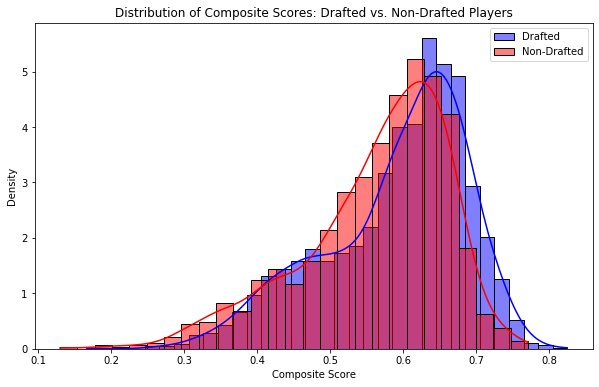

In [639]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and 'Composite_Score_Player' is the column with composite scores



# Descriptive statistics: Compare the mean composite scores between drafted and non-drafted players
composite_score_means = df.groupby('Drafted')['Composite_Score_Player'].mean().reset_index()

# Display the means
print("Mean Composite Score by Draft Status:")
print(composite_score_means)

# Visualization: Plot the distribution of composite scores for drafted vs. non-drafted players
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Drafted'] == 1]['Composite_Score_Player'], kde=True, color='blue', label='Drafted', stat="density")
sns.histplot(df[df['Drafted'] == 0]['Composite_Score_Player'], kde=True, color='red', label='Non-Drafted', stat="density")
plt.title('Distribution of Composite Scores: Drafted vs. Non-Drafted Players')
plt.xlabel('Composite Score')
plt.ylabel('Density')
plt.legend()
plt.show()



In [576]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Composite_Score_Player' is the column with composite scores

# Ensure that 'Round' is numeric for correlation calculation
df['Round'] = pd.to_numeric(df['Round'], errors='coerce')

# Calculate the correlation between the draft round and the composite score
correlation = df['Round'].corr(df['Composite_Score_Player'])

# Display the correlation result
correlation

-0.14423445772832963

In [577]:
df["Round"]

0       1
1       5
2       6
3       4
4       4
       ..
3472    8
3473    8
3474    8
3475    8
3476    8
Name: Round, Length: 3477, dtype: int64

In [700]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Composite_Score_Player' is the column with composite scores

# Ensure that 'Round' is numeric for correlation calculation
df['Round'] = pd.to_numeric(df['Round'], errors='coerce')

# Drop any rows where 'Round' or 'Composite_Score_Player' is NaN, as correlation cannot be calculated with NaNs
df_cleaned = df.dropna(subset=['Round', 'Composite_Score_Player'])

# Calculate the correlation between the draft round and the composite score
correlation = df_cleaned['Round'].corr(df_cleaned['Composite_Score_Player'])

# Display the correlation result
print(f"Correlation between Draft Round and Composite Score: {correlation:.2f}")


Correlation between Draft Round and Composite Score: -0.14


In [710]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Columns to minimize and maximize
columns_to_minimize = ['Sprint_40yd', 'Agility_3cone', 'Shuttle']
columns_to_maximize = ['Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump']

# Group by 'Position_Type' and calculate the mean for each of the selected columns
position_means_min = df.groupby('Position')[columns_to_minimize].mean()
position_means_max = df.groupby('Position')[columns_to_maximize].mean()

# Normalize the data to bring everything to the same scale (0-1)
position_means_min_normalized = (position_means_min - position_means_min.min()) / (position_means_min.max() - position_means_min.min())
position_means_max_normalized = (position_means_max - position_means_max.min()) / (position_means_max.max() - position_means_max.min())

# Since we want to minimize the columns in position_means_min, we subtract them from 1 to reverse the scale
position_means_min_normalized = 1 - position_means_min_normalized

# Combine the normalized scores into a single DataFrame
combined_scores = position_means_min_normalized.join(position_means_max_normalized)

# Calculate a composite score by averaging the normalized values
combined_scores['Composite_Score'] = combined_scores.mean(axis=1)

# Map the composite score back to the original dataframe based on Position_Type
df2 = df.merge(combined_scores['Composite_Score'], on='Position', how='left')

/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_820/2438037880.py:27: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Composite_Score_x'} in the result is deprecated and will raise a MergeError in a future version.
  df2 = df.merge(combined_scores['Composite_Score'], on='Position', how='left')


In [711]:
# Map the composite score back to the original dataframe based on Position_Type
df = df.merge(combined_scores['Composite_Score'], on='Position', how='left')

# Convert the 'Drafted' column to binary values if not already done (assuming 'Yes' = 1 and 'No' = 0)
df['Drafted'] = df['Drafted'].map({'Yes': 1, 'No': 0})

# Calculate the proportion of "Yes" to "No" in the drafted column
drafted_proportion = df['Drafted'].mean()  # This gives the proportion of "Yes"

# Add this proportion as a new column in the DataFrame
df['Drafted_Proportion'] = drafted_proportion

# Calculate the correlation between Composite_Score and Drafted
correlation = df['Composite_Score'].corr(df['Drafted'])

# Display the correlation result
print(f"Correlation between Composite Score and being drafted: {correlation:.2f}")

# Display the first few rows of the DataFrame to check the new columns
print(df[['Position', 'Composite_Score', 'Drafted', 'Drafted_Proportion']].head())


/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_820/3355541641.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Composite_Score_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = df.merge(combined_scores['Composite_Score'], on='Position', how='left')


KeyError: 'Composite_Score'

Apart from the "Team" and "Age" column, all the existing variables have no null values.

In [712]:
(df.isnull().sum()/(len(df)))*100

Player                                   0.000000
Age                                      0.000000
School                                   0.000000
Height                                   0.000000
Weight                                   0.000000
Sprint_40yd                              0.000000
Vertical_Jump                            0.000000
Bench_Press_Reps                         0.000000
Broad_Jump                               0.000000
Agility_3cone                            0.000000
Shuttle                                  0.000000
BMI                                      0.000000
Player_Type                              0.000000
Position_Type                            0.000000
Position                                 0.000000
Drafted                                100.000000
Team                                     0.000000
Round                                    0.000000
Pick                                    35.174001
Composite_Score_x                        0.000000


In [582]:
from pandas import factorize

labels, categories = factorize(df["Drafted"])
df["labels"] = labels
abs(df["Position_Type"].corr(df["labels"]))

TypeError: unsupported operand type(s) for /: 'str' and 'int'

# 3. Exploratory Data Analysis

### <b >Summary Statistics: Schools

We find that the majority of players get drafted, "With" 65% of the values in the "Drafted" column being "Yes"

In [ ]:
perc_drafted = len(df[df["Drafted"] == "Yes"]) / len(df) * 100
print("Percentage of drafted players:", perc_drafted)

Percentage of drafted players: 64.82599942479149


We can also identify the proportion of players being drafted for each school:

In [ ]:
c = df.groupby(["School", "Drafted"]).size().unstack()
c[np.isnan(c)] = 0
c = c.divide(c.sum(1), axis=0)
c

Drafted,No,Yes
School,,
Abilene Christian,0.000000,1.000000
Air Force,1.000000,0.000000
Akron,0.500000,0.500000
Ala-Birmingham,0.000000,1.000000
Alabama,0.247525,0.752475
...,...,...
William & Mary,0.200000,0.800000
Wisconsin,0.333333,0.666667
Wyoming,0.142857,0.857143


Out of 253 schools, we find that 47 of them had a very successful draft, with 100% of their players being drafted

In [ ]:
filtered_df = c[c['No'] == 0.0].sum()
filtered_df

Drafted
No      0.0
Yes    47.0
dtype: float64

Out of 253 schools, 48 of them had 0% of their players being drafted

In [ ]:
filtered_df = c[c['Yes'] == 0.0].sum()
filtered_df

Drafted
No     48.0
Yes     0.0
dtype: float64

We find that more schools present in our data have a majority of players being accepted to the draft: 145 schools with more than 50% of their prospects being drafted, and 82 having the most of their prospects being rejected from the draft. This seems to indicate that most of the schools will have a successful draft.

In [ ]:
highlighted_df = c[c['Yes'] > c['No']]
highlighted_df

Drafted,No,Yes
School,,
Abilene Christian,0.000000,1.000000
Ala-Birmingham,0.000000,1.000000
Alabama,0.247525,0.752475
Appalachian St.,0.272727,0.727273
Arizona,0.235294,0.764706
...,...,...
West. Michigan,0.300000,0.700000
Western Kentucky,0.111111,0.888889
William & Mary,0.200000,0.800000


In [ ]:
highlighted_df = c[c['Yes'] < c['No']]
highlighted_df

Drafted,No,Yes
School,,
Air Force,1.000000,0.000000
Alabama A&M,1.000000,0.000000
Alabama St.,1.000000,0.000000
Alcorn St.,1.000000,0.000000
Army,1.000000,0.000000
...,...,...
West Georgia,0.666667,0.333333
West Liberty,1.000000,0.000000
West Texas A&M,0.666667,0.333333


These results do not necesarily take into account the number of players being drafted. For instance, a school could only have 1 players presenting for the draft and be accepted, which will be accounted as 100% of the school's players being drafted. Let's compare these results with school having 3 or more players per school.

In [ ]:
c = df.groupby(["School", "Player"]).size().reset_index()

# Count the number of players per school
player_counts = c["School"].value_counts()

# Filter schools that have 10 or more players
schools_with_10_or_more = player_counts[player_counts >= 3]

# Filter the original dataframe to only include these schools
filtered_df = df[df["School"].isin(schools_with_10_or_more.index)]

# Display the filtered dataframe
c = filtered_df.groupby(["School", "Drafted"]).size().unstack()
c[np.isnan(c)] = 0
c = c.divide(c.sum(1), axis=0)

When only taking account schools with 3 players or more, we find a drastic reduction of schools with either: 100% of players being drafted, or 100% of the players getting rejected from the draft. Only 6 Schools with 3 players or more presenting for the draft will have 100% of their players accepted, and only 4 schools with 3 players or more will have all their players rejected from the draft.

In [ ]:
filtered_df = c[c['No'] == 0.0].sum()
filtered_df

Drafted
No     0.0
Yes    6.0
dtype: float64

In [ ]:
filtered_df = c[c['Yes'] == 0.0].sum()
filtered_df

Drafted
No     4.0
Yes    0.0
dtype: float64

This brings us to inspect the schools with the highest number of players getting drafted, and the proportion of drafted players for each respective school. We find that schools with the highest number of players considered for the draft, have a high proportion of players being drafted.

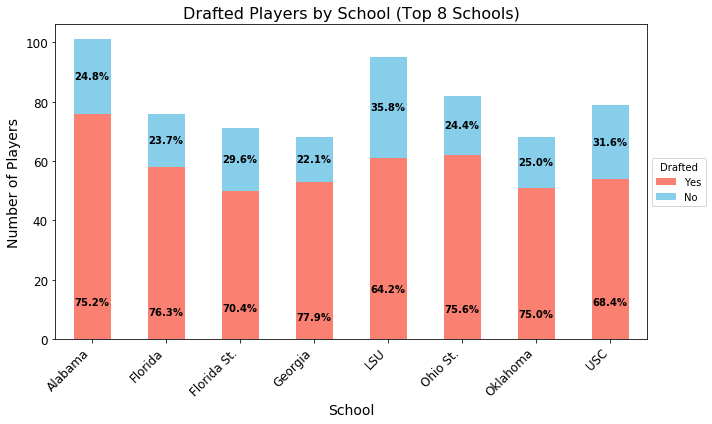

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by 'School' and 'Drafted' and get the count
Drafted_players_by_school = df.groupby(['School', 'Drafted']).size().reset_index(name='count')

# Get the top 5 schools based on the count of 'Yes'
top_schools = Drafted_players_by_school[
    Drafted_players_by_school['Drafted'] == 'Yes'
].sort_values(by='count', ascending=False)[:8]['School']

# Filter the original data to include only the top 5 schools
top_schools_data = Drafted_players_by_school[
    Drafted_players_by_school['School'].isin(top_schools)
]

# Pivot the data to have 'Yes' and 'No' in separate columns
pivot_data = top_schools_data.pivot(index='School', columns='Drafted', values='count').fillna(0)

# Calculate totals and percentages
pivot_data['Total'] = pivot_data.sum(axis=1)
pivot_data['Yes%'] = (pivot_data['Yes'] / pivot_data['Total']) * 100
pivot_data['No%'] = (pivot_data['No'] / pivot_data['Total']) * 100

# Plotting
ax = pivot_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 6))

# Adding percentage annotations
for i in range(pivot_data.shape[0]):
    yes_count = pivot_data['Yes'].iloc[i]
    no_count = pivot_data['No'].iloc[i]
    total_count = pivot_data['Total'].iloc[i]
    
    yes_percent = pivot_data['Yes%'].iloc[i]
    no_percent = pivot_data['No%'].iloc[i]
    
    # Yes percentage on the orange part
    ax.text(i, no_count / 2, f'{yes_percent:.1f}%', ha='center', va='center', color='black', weight='bold')
    
    # No percentage on the blue part
    ax.text(i, yes_count + no_count / 2, f'{no_percent:.1f}%', ha='center', va='center', color='black', weight='bold')

# Customizing the plot
plt.title('Drafted Players by School (Top 8 Schools)', fontsize=16)
plt.ylabel('Number of Players', fontsize=14)
plt.xlabel('School', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Move the legend outside the plot
plt.legend(title="Drafted", loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout
plt.tight_layout()

plt.show()


Let's identify the schools with the highest average stats for their players. Since some schools only had 1-2 players presenting for the draft, the average mean stat for the drill might not be an accurate indication of whether the school has pre-dispositions for players being drafted. Let's look at schools with 10 players or more presenting to the draft.

Now let's compare the maximum average performance of the top schools against the overall average performance, the average performance for players drafted, and average performance for non-drafted players. We find that schools, with 30 players or more, and with the highest average performance in either of the drills, will tend to have a high proportion of drafted players. We chose schools with 30 players presenting for the draft to ensure that the results are less susceptible to variability

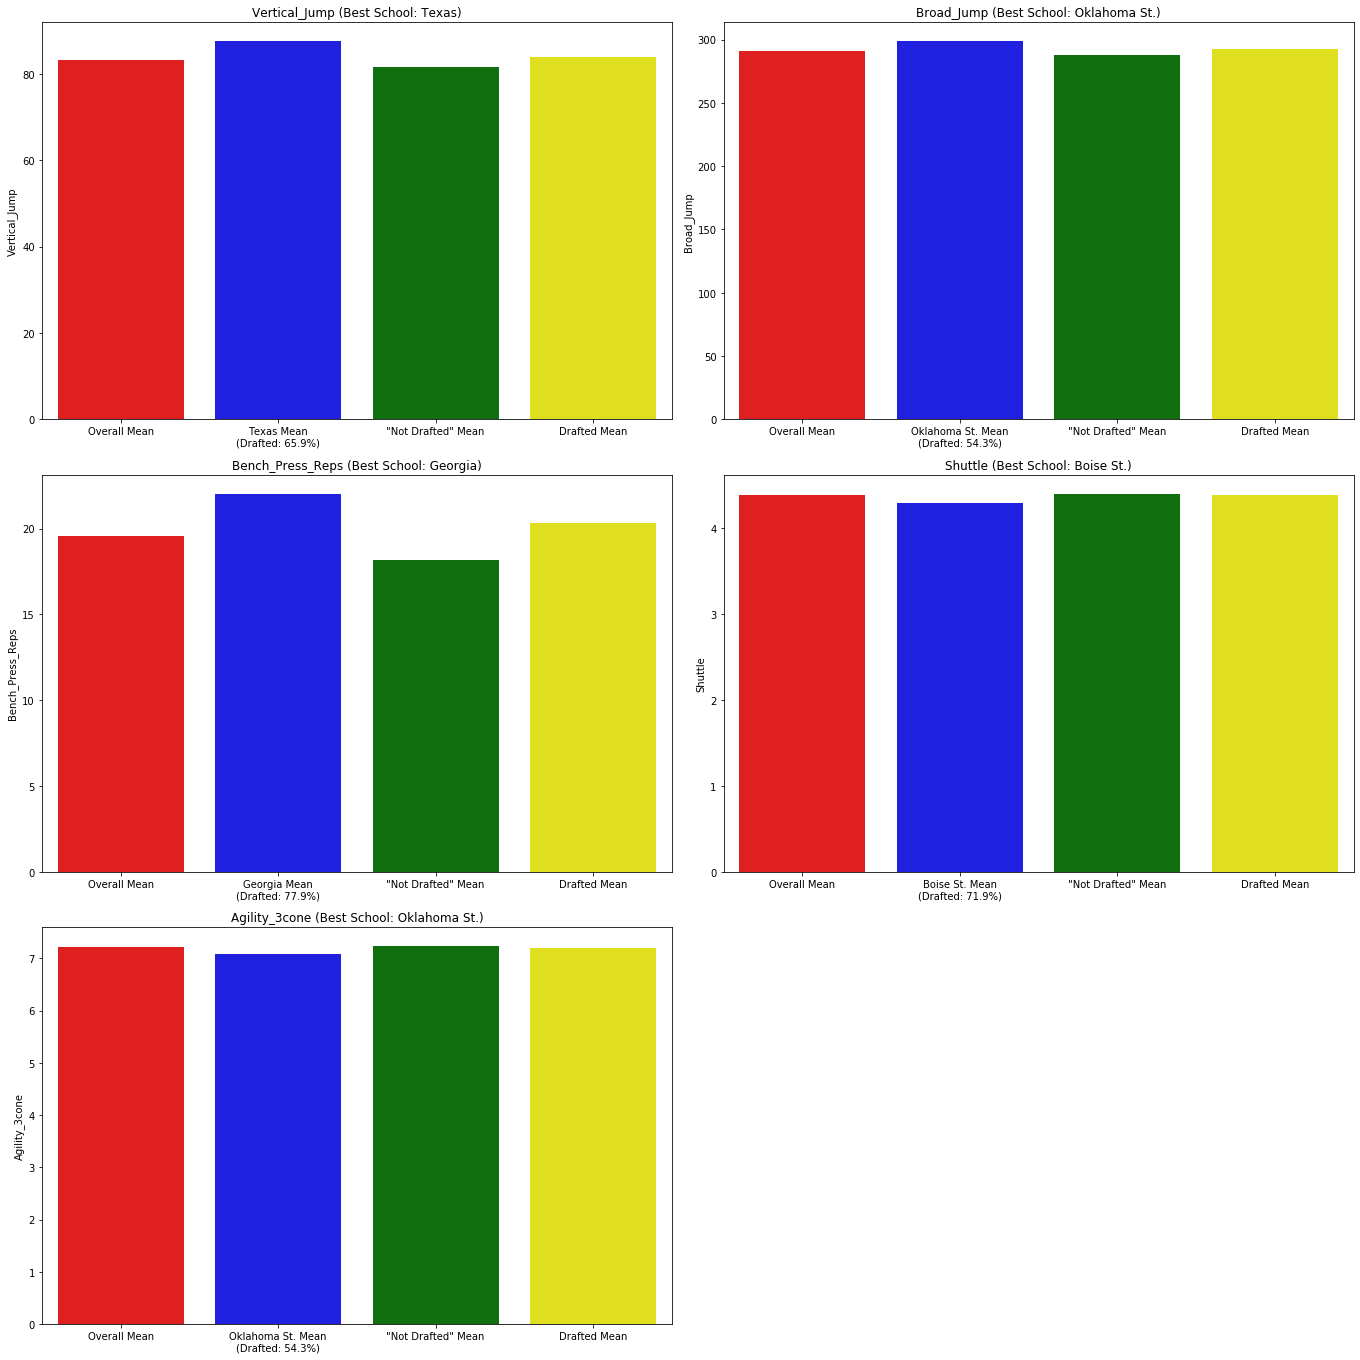

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter schools that have 30 or more players
schools_with_5_or_more = player_counts[player_counts >= 30]

# Filter the original dataframe to only include these schools
filtered_df = df[df["School"].isin(schools_with_5_or_more.index)]
# Group by 'School' and calculate the mean for each metric
school_means = filtered_df.groupby("School").mean()

# Identify the schools with the highest/lowest performance for each metric
highest_vertical_jump_school = school_means['Vertical_Jump'].idxmax()
highest_broad_jump_school = school_means['Broad_Jump'].idxmax()
highest_bench_press_school = school_means['Bench_Press_Reps'].idxmax()
lowest_shuttle_school = school_means['Shuttle'].idxmin()
lowest_agility_3cone_school = school_means['Agility_3cone'].idxmin()

# Create a dictionary of the best schools for each metric
best_schools = {
    'Vertical_Jump': highest_vertical_jump_school,
    'Broad_Jump': highest_broad_jump_school,
    'Bench_Press_Reps': highest_bench_press_school,
    'Shuttle': lowest_shuttle_school,
    'Agility_3cone': lowest_agility_3cone_school
}

# Calculate the percentage of players being drafted for each school
drafted_players_by_school = df.groupby(['School', 'Drafted']).size().reset_index(name='count')

# Pivot the data to have 'Yes' and 'No' in separate columns
pivot_data = drafted_players_by_school.pivot(index='School', columns='Drafted', values='count').fillna(0)

# Calculate totals and percentages
pivot_data['Total'] = pivot_data.sum(axis=1)
pivot_data['Drafted%'] = (pivot_data['Yes'] / pivot_data['Total']) * 100
# Define the competencies/skills
competencies = ['Vertical_Jump', 'Broad_Jump', 'Bench_Press_Reps', 'Shuttle', 'Agility_3cone']

# Create bar plots for each competency, showing the overall mean and the best school's mean
plt.figure(figsize=(19, 19))
for i, skill in enumerate(competencies, 1):
    plt.subplot(3, 2, i)
    
    # Calculate the overall mean
    overall_mean = df[skill].mean()
    
    # Identify the best school for the current skill
    best_school = best_schools[skill]
    best_school_mean = school_means.loc[best_school, skill]
    
    # Get the percentage of players drafted from the best school
    drafted_percentage = pivot_data.loc[best_school, 'Drafted%'] if best_school in pivot_data.index else 0
    
    # Calculate the mean for "Not Drafted" players
    not_drafted_mean = df[df['Drafted'] == 'No'][skill].mean()

    # Calculate the mean for "Drafted" players
    drafted_mean = df[df['Drafted'] == 'Yes'][skill].mean()
    
    # Plot the means using bar plots
    means = [overall_mean, best_school_mean, not_drafted_mean, drafted_mean]
    labels = [
        'Overall Mean',
        f'{best_school} Mean\n(Drafted: {drafted_percentage:.1f}%)',
        '"Not Drafted" Mean',
        "Drafted Mean"
    ]
    colors = ['red', 'blue', 'green', "yellow"]
    
    sns.barplot(x=labels, y=means, palette=colors)
    
    plt.title(f'{skill} (Best School: {best_school})')
    plt.ylabel(skill)

plt.tight_layout()
plt.show()


### <b> Teams with highest player stats </b>

In [ ]:
# Group by 'Team' and calculate the mean for each metric
team_means = df.groupby("Team").mean()

# Find the team with the highest 'Vertical_Jump', 'Broad_Jump', and 'Bench_Press_Reps'
highest_vertical_jump_team = team_means['Vertical_Jump'].idxmax()
highest_broad_jump_team = team_means['Broad_Jump'].idxmax()
highest_bench_press_team = team_means['Bench_Press_Reps'].idxmax()

# Find the team with the lowest 'Shuttle' and 'Agility_3cone'
lowest_shuttle_team = team_means['Shuttle'].idxmin()
lowest_agility_3cone_team = team_means['Agility_3cone'].idxmin()

# Create a DataFrame to display the results
result = pd.DataFrame({
    'Metric': ['Vertical_Jump', 'Broad_Jump', 'Bench_Press_Reps', 'Shuttle', 'Agility_3cone'],
    'Team': [highest_vertical_jump_team, highest_broad_jump_team, highest_bench_press_team, lowest_shuttle_team, lowest_agility_3cone_team],
    'Value': [
        team_means['Vertical_Jump'].max(),
        team_means['Broad_Jump'].max(),
        team_means['Bench_Press_Reps'].max(),
        team_means['Shuttle'].min(),
        team_means['Agility_3cone'].min()
    ]
})

# Display the results
result

,Metric,Team,Value
0,Vertical_Jump,Dallas Cowboys,86.667345
1,Broad_Jump,Dallas Cowboys,297.780412
2,Bench_Press_Reps,San Diego Chargers,22.174697
3,Shuttle,Dallas Cowboys,4.318745
4,Agility_3cone,Philadelphia Eagles,7.105488


Despite having the highest number of drafted players, none of the top 8 teams with the highest number of most drafted players appear to have the highest average player stats.

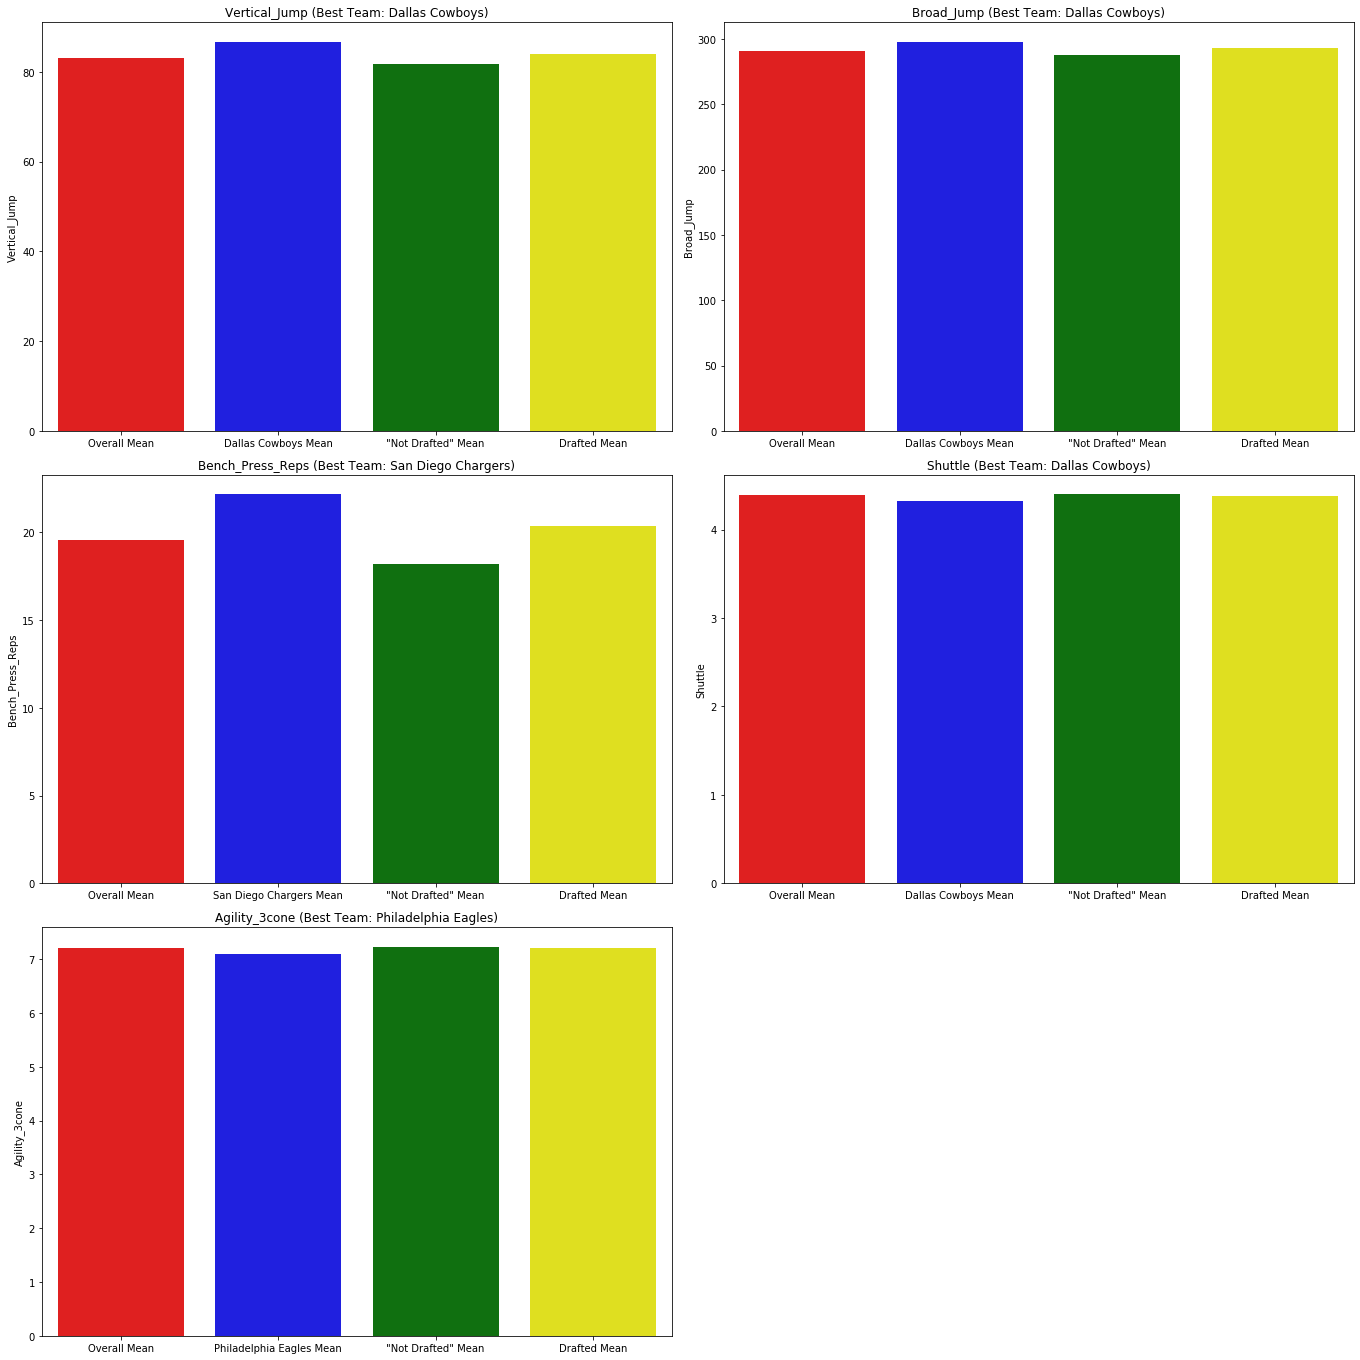

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'Team' and calculate the mean for each metric
team_means = df.groupby("Team").mean()

# Identify the teams with the highest/lowest performance for each metric
highest_vertical_jump_team = team_means['Vertical_Jump'].idxmax()
highest_broad_jump_team = team_means['Broad_Jump'].idxmax()
highest_bench_press_team = team_means['Bench_Press_Reps'].idxmax()
lowest_shuttle_team = team_means['Shuttle'].idxmin()
lowest_agility_3cone_team = team_means['Agility_3cone'].idxmin()

# Create a dictionary of the best teams for each metric
best_teams = {
    'Vertical_Jump': highest_vertical_jump_team,
    'Broad_Jump': highest_broad_jump_team,
    'Bench_Press_Reps': highest_bench_press_team,
    'Shuttle': lowest_shuttle_team,
    'Agility_3cone': lowest_agility_3cone_team
}

# Define the competencies/skills
competencies = ['Vertical_Jump', 'Broad_Jump', 'Bench_Press_Reps', 'Shuttle', 'Agility_3cone']

# Create bar plots for each competency, showing the overall mean and the best team's mean
plt.figure(figsize=(19, 19))
for i, skill in enumerate(competencies, 1):
    plt.subplot(3, 2, i)
    
    # Calculate the overall mean
    overall_mean = df[skill].mean()
    
    # Identify the best team for the current skill
    best_team = best_teams[skill]
    best_team_mean = team_means.loc[best_team, skill]
    
    # Calculate the mean for "Not Drafted" players
    not_drafted_mean = df[df['Team'] == 'Not Drafted'][skill].mean()

    # Calculate the mean for "Not Drafted" players
    drafted_mean = df[df['Drafted'] == 'Yes'][skill].mean()
    
    # Plot the means using bar plots
    means = [overall_mean, best_team_mean, not_drafted_mean, drafted_mean]
    labels = ['Overall Mean', f'{best_team} Mean', '"Not Drafted" Mean', "Drafted Mean"]
    colors = ['red', 'blue', 'green', "yellow"]
    
    sns.barplot(x=labels, y=means, palette=colors)
    
    plt.title(f'{skill} (Best Team: {best_team})')
    plt.ylabel(skill)

plt.tight_layout()
plt.show()


### <b> When do players usually get drafted? </b>

We find that 22 years old is the most common age for players to get drafted based on our data with 933 being drafted at that age against 285 being rejected from the draft. Interestingly, we find a much higher proportion of players being rejected than accepted at 23 years old, wih 218/487 being rejected. As expected the older a player is, the less likely the player is to get drafted

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


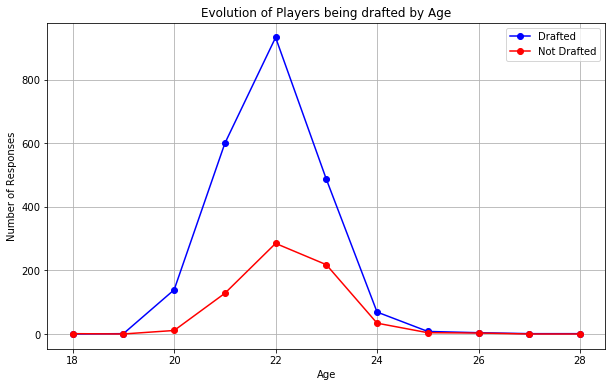

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with 'Age', 'Drafted', and possibly 'Gender' columns

# Grouping the data by age
age_groups = df.groupby(["Age"])

# Initialize lists to store the counts of 'Yes' and 'No' responses
yes_counts = []
no_counts = []

# Loop through each age group and count the 'Yes' and 'No' responses
for age, group in age_groups:
    yes_count = group["Drafted"].value_counts().get('Yes', 0)
    no_count = group["Drafted"].value_counts().get('No', 0)
    yes_counts.append((age, yes_count))
    no_counts.append((age, no_count))

# Convert to DataFrame for easy plotting
yes_df = pd.DataFrame(yes_counts, columns=['Age', 'Drafted'])
no_df = pd.DataFrame(no_counts, columns=['Age', 'Not Drafted'])

# Plotting the evolution of 'Yes' and 'No' responses
plt.figure(figsize=(10, 6))
plt.plot(yes_df['Age'], yes_df['Drafted'], marker='o', linestyle='-', color='blue', label='Drafted')
plt.plot(no_df['Age'], no_df['Not Drafted'], marker='o', linestyle='-', color='red', label='Not Drafted')
plt.title('Evolution of Players being drafted by Age')
plt.xlabel('Age')
plt.ylabel('Number of Responses')
plt.grid(True)
plt.legend()
plt.show()


While this show a general pattern of players being drafted by age, is the same for each position ?

By comparing each position, we find that the majority of players get drafted at 22 for most of positions. However, we do find that Running backs have a higher proportion of players drafted at 21. For QB, and P positions, the majority get drafted at 23 years old.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


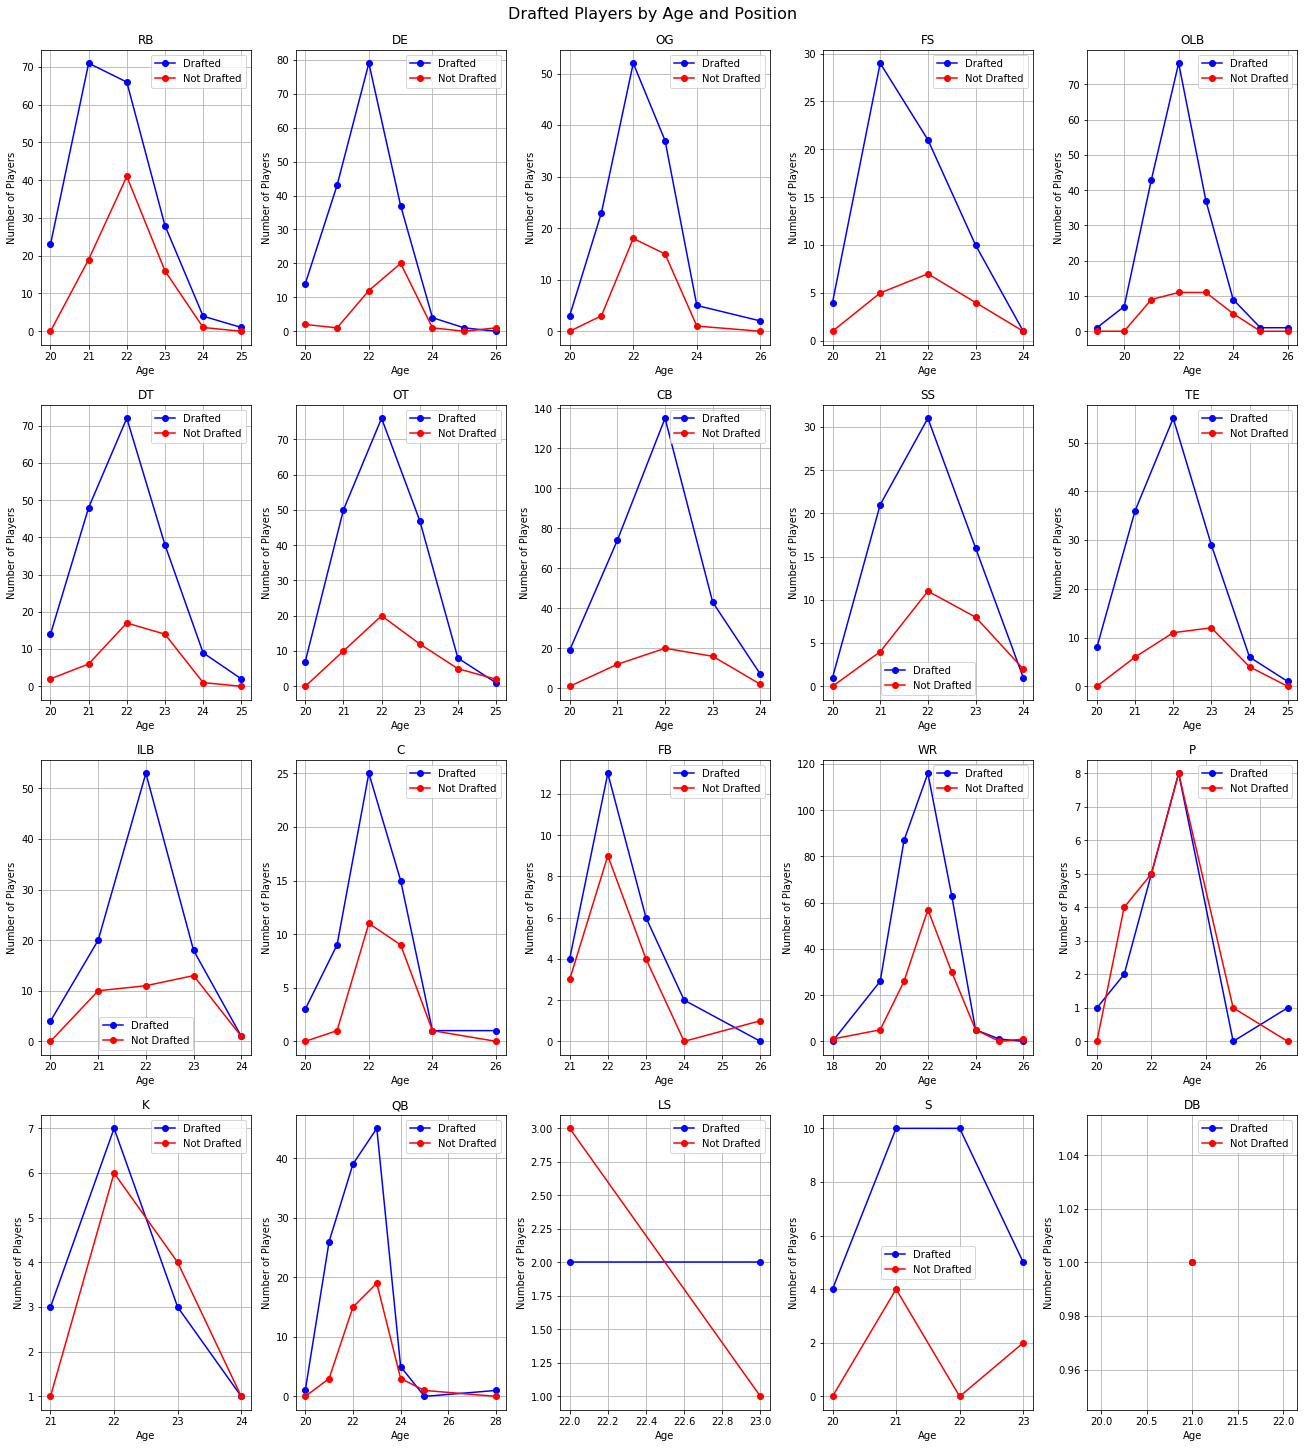

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by Position, Age, and Drafted status
position_age_groups = df.groupby(["Position", "Age", "Drafted"]).size().unstack().fillna(0).reset_index()

# Unique positions and subplot layout
positions = df['Position'].unique()
n_cols = 5
n_rows = -(-len(positions) // n_cols)  # Ceiling division for rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Plot each position
for i, position in enumerate(positions):
    pos_data = position_age_groups[position_age_groups['Position'] == position]
    axes[i].plot(pos_data['Age'], pos_data.get('Yes', 0), marker='o', linestyle='-', color='blue', label='Drafted')
    axes[i].plot(pos_data['Age'], pos_data.get('No', 0), marker='o', linestyle='-', color='red', label='Not Drafted')
    axes[i].set_title(position)
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Number of Players')
    axes[i].grid(True)
    axes[i].legend()

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Drafted Players by Age and Position', fontsize=16)
plt.show()


### <b> Correlation Analysis: Which variables correlate? Are there any issues of collinearity within our data? </b>

In [ ]:
# Select only numerical columns and the 'drafted' column
numerical_columns = df.select_dtypes(include='number')
selected_columns = numerical_columns.copy()

# Ensure 'drafted' is in the selected columns
if 'drafted' not in selected_columns.columns:
    selected_columns['Drafted'] = df['Drafted']
selected_columns = selected_columns.loc[:, ["Weight", "Vertical_Jump", "Drafted"]]

Let's identify the moderate to strong correlations between our numerical variables:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is already populated with the necessary columns

# Separate the DataFrame based on Drafted status
df_drafted = df[df['Drafted'] == 'Yes'].drop(columns='Drafted')
df_nondrafted = df[df['Drafted'] == 'No'].drop(columns='Drafted')

# Function to calculate and filter correlations (including negative correlations)
def filter_correlations(df, min_corr, max_corr):
    corr_matrix = df.corr()
    filtered_corr = corr_matrix[((corr_matrix >= min_corr) & (corr_matrix <= max_corr)) | ((corr_matrix <= -min_corr) & (corr_matrix >= -max_corr))].dropna(axis=0, how='all').dropna(axis=1, how='all')
    return filtered_corr

# Calculate correlations for each group
corr_drafted = df_drafted.corr()
corr_nondrafted = df_nondrafted.corr()

# Filter correlations including both positive and negative correlations
moderate_corr_all = filter_correlations(df, 0.4, 0.6)
strong_corr_all = filter_correlations(df, 0.6, 0.8)
very_strong_corr_all = filter_correlations(df, 0.8, 0.99)

We find that variables associated to athletic performance will tend to be negatively affected by Weight. The exception is Bench Press reps, which requires strength, and in turn requires muscle mass (additional weight). Athletic performances will tend to have moderate to strong relationships between one another. Our results show that a higher number Bench press reps tend to negatively affect drills involving jumping, speed, or agility. This is consistent with our assumptions, since weight correlates with higher bench press reps. Since weight also negatively affects these drills, then these results make sense. Similarly, Height and BMI tends to show the same relationship with these other variables at significant level.

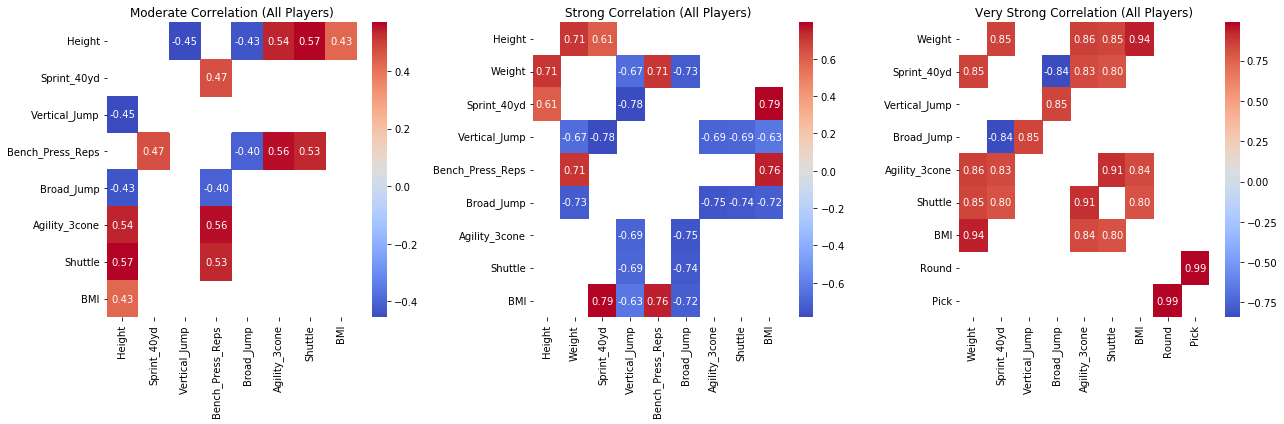

In [ ]:
# Set up the figure with three subplots for all players' correlations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Overall players' correlation heatmaps
if not moderate_corr_all.empty:
    sns.heatmap(moderate_corr_all, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
    axes[0].set_title("Moderate Correlation (All Players)")
if not strong_corr_all.empty:
    sns.heatmap(strong_corr_all, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
    axes[1].set_title("Strong Correlation (All Players)")
if not very_strong_corr_all.empty:
    sns.heatmap(very_strong_corr_all, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[2])
    axes[2].set_title("Very Strong Correlation (All Players)")

plt.tight_layout()
plt.show()

<b> Comparing correlations differences based on whether the player gets drafted </b>

We find that the status of the drafted player has little change with regards to the correlation with other variables. Performance in the different drills seem to not differ based on whether the player gets draftred or not.

In [ ]:
df.columns
selected_columns = df.loc[:,['Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Sprint_40yd', "Shuttle", "Drafted"]]

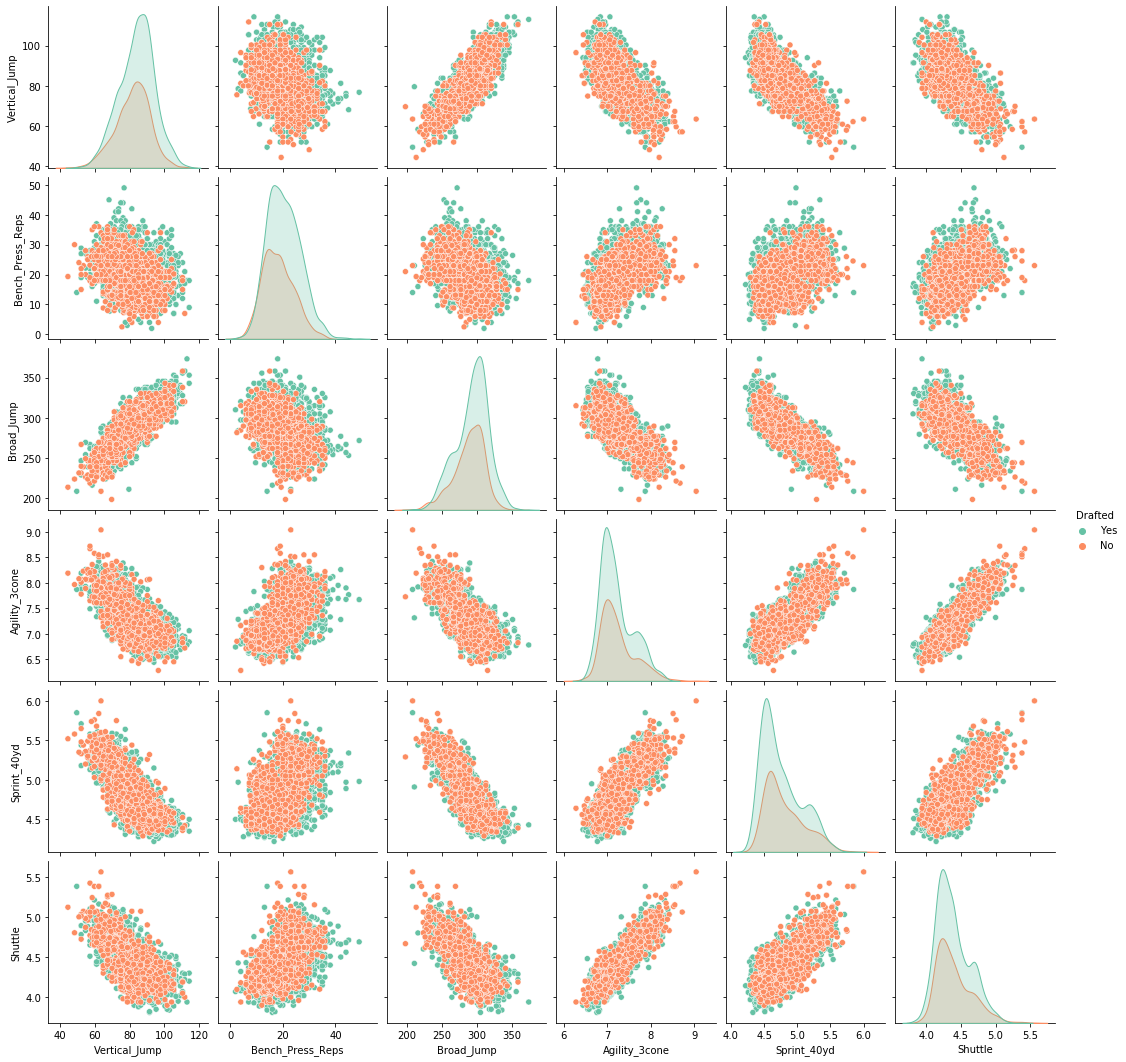

In [ ]:
sns.pairplot(selected_columns, hue = 'Drafted', palette = 'Set2')

### <b> Collinearity Check

We find strong relationships between our variables. let's identify those that might create collinearity issues:

While the other variables do present some collinearity, they still bring some insightful information on whether the player will be drafted or not. However, Having the Height and Weight is redundant, since they are both used to calculate the BMI

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Assuming df_corr is the original DataFrame with all relevant columns
numerical_columns = df.select_dtypes(include='number')

X = numerical_columns.dropna()
# Convert to a NumPy array for VIF calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Let's remove the Height and Weight columns:

In [ ]:
df = df.drop(columns=["Height", "Weight"])

In [ ]:
df.head()

,Player,Age,School,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,...,Round,Pick,Weight_Strat,Sprint_40yd_Strat,Broad_Jump_Strat,Agility_3cone_Strat,Vertical_Jump_Strat,Shuttle_Strat,BMI_Strat,Height_Strat
0,Beanie Wells,20.0,Ohio St.,4.38,85.09,25.0,325.12,NaN,NaN,31.004194,...,1,31,"(103.225, 110.353]","(4.347, 4.474]","(323.306, 335.824]",NaN,"(84.364, 89.354]",NaN,"(29.849, 31.497]","(1.836, 1.867]"
1,Will Davis,22.0,Illinois,4.84,83.82,27.0,292.10,7.38,4.45,33.510073,...,6,204,"(117.48, 124.608]","(4.729, 4.856]","(285.75, 298.269]","(7.266, 7.463]","(79.375, 84.364]","(4.435, 4.56]","(33.145, 34.793]","(1.867, 1.898]"
2,Herman Johnson,24.0,LSU,5.50,NaN,21.0,NaN,NaN,NaN,41.005821,...,5,167,"(160.248, 167.376]","(5.491, 5.619]",NaN,NaN,NaN,NaN,"(39.736, 41.384]","(1.99, 2.021]"
3,Rashad Johnson,23.0,Alabama,4.49,93.98,15.0,304.80,7.09,4.23,28.312463,...,3,95,"(88.969, 96.097]","(4.474, 4.601]","(298.269, 310.787]","(7.069, 7.266]","(89.354, 94.343]","(4.185, 4.31]","(28.201, 29.849]","(1.774, 1.805]"
4,Cody Brown,22.0,Connecticut,4.76,92.71,26.0,304.80,7.10,4.40,31.327425,...,2,63,"(110.353, 117.48]","(4.729, 4.856]","(298.269, 310.787]","(7.069, 7.266]","(89.354, 94.343]","(4.31, 4.435]","(29.849, 31.497]","(1.867, 1.898]"


### <b> Some schools might be have better training facilities and staff and therefore might have a greater chance of having drafter football players.

We might also be interested in looking at the percentage of players which are drafted:

In [ ]:
Drafted_players_by_school.sort_values(by=['count'], ascending=False)

,School,Drafted,count
26,Clemson,Yes,31
113,Ohio St.,Yes,26
114,Oklahoma,Yes,25
68,LSU,Yes,24
142,Stanford,Yes,23
...,...,...,...
74,Louisiana-Lafayette,Yes,1
72,Louisiana,Yes,1
71,Lindenwood,Yes,1
70,Liberty,Yes,1


In [ ]:
Num_player_school = df.groupby(['School','Player']).size().reset_index(name='count')["School"].value_counts()
Num_player_school

Clemson                 31
Ohio St.                26
Oklahoma                25
LSU                     24
Stanford                23
                        ..
Louisiana-Lafayette      1
Louisiana                1
Lindenwood               1
Liberty                  1
Missouri Western St.     1
Name: School, Length: 185, dtype: int64

To identify outliers ze cqn use the z-score as a reference. It is a statistical measure that quantifies the distance between a data point and the mean of a dataset. It's expressed in terms of standard deviations. It indicates how many standard deviations a data point is from the mean of the distribution. A rule of thumb with regards to outliers, is a z-score of 3. Any value with is above or below 3 standard deviation from the mean will be qualified as an outlier in our exploratory analysis. 

### Cleaning out columns

Let's clean up the formatting for the players.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Step 1: Identify highly correlated columns
correlation_matrix = df.corr().abs()

# We want to find pairs with a correlation of 70% or more
high_corr_pairs = correlation_matrix.stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] >= 0.7]

# Step 2: Function to predict and fill missing values using multiple explanatory variables
def fill_missing_values_multivariable(df, col_to_fill, explanatory_vars):
    # Separate the data into those with and without missing values
    non_null_df = df[df[col_to_fill].notnull()]
    null_df = df[df[col_to_fill].isnull()]
    
    # If there's no missing value, return the column as is
    if null_df.empty:
        return df[col_to_fill]
    
    # Ensure that we only use explanatory variables that are not null
    explanatory_vars = [var for var in explanatory_vars if var in df.columns and df[var].isnull().sum() == 0]
    
    # Train a linear regression model on non-null data
    X_train = non_null_df[explanatory_vars]
    y_train = non_null_df[col_to_fill]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict the missing values
    X_predict = null_df[explanatory_vars]
    y_predict = model.predict(X_predict)
    
    # Fill the missing values with the predictions
    df.loc[df[col_to_fill].isnull(), col_to_fill] = y_predict
    
    return df[col_to_fill]

# Step 3: Apply the model to fill missing values for each column
columns_to_predict = ['Shuttle', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone']

for col in columns_to_predict:
    explanatory_vars = [c for c in columns_to_predict if c != col]
    df[col] = fill_missing_values_multivariable(df, col, explanatory_vars)

# Display the DataFrame after filling missing values
df

ValueError: at least one array or dtype is required

# 4. Feature Selection 

# 5. Hypothesis Testing

H0: our hypothesis is that there is little significance between non-drafted and drafted players for the mean athletic performances

df.columns

Significénce level of 0.05: 5% chance of rejecting the null hypothesis if true.

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming df is your DataFrame and contains the relevant data
position_types = df['Position_Type'].unique()

# Loop through each pair of position types and perform a t-test
results = []
for i, pos1 in enumerate(position_types):
    for pos2 in position_types[i+1:]:
        group1 = df[df['Position_Type'] == pos1]['Bench_Press_Reps'].dropna()
        group2 = df[df['Position_Type'] == pos2]['Bench_Press_Reps'].dropna()
        
        if len(group1) > 0 and len(group2) > 0:
            # Perform an independent t-test
            t_stat, p_value = ttest_ind(group1, group2)
            
            # Save the results only if they reject the null hypothesis
            if p_value < 0.05:
                results.append({
                    'Position 1': pos1,
                    'Position 2': pos2,
                    'T-statistic': t_stat,
                    'P-value': p_value
                })

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Display only the results that reject the null hypothesis
results_df

,Position 1,Position 2,T-statistic,P-value
0,Backs/Receivers,Defensive Lineman,-34.669186,3.647682e-201
1,Backs/Receivers,Offensive Lineman,-34.306248,3.366333e-199
2,Backs/Receivers,Defensive Back,6.598861,5.346671e-11
3,Backs/Receivers,Linebacker,-18.533179,9.178232e-70
4,Backs/Receivers,Kicking Specialist,9.074849,3.855833e-19
5,Defensive Lineman,Defensive Back,38.293925,7.508845e-208
6,Defensive Lineman,Linebacker,11.966589,1.111420e-30
7,Defensive Lineman,Kicking Specialist,25.570276,1.449313e-98
8,Defensive Lineman,Other Special,5.937160,5.353995e-09
9,Offensive Lineman,Defensive Back,38.253905,1.608013e-210


# 5. Xgboost model

Only selecting relevant columns for the model

In [ ]:
df = df[['School','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle','Player_Type','Position_Type','Position','Drafted']]

Extracting feature and target arrays based on the dataset. Since our target are players getting drafter we will have it as our target and therefore store it inside of y.

In [ ]:
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = df.drop('Drafted', axis=1), df[['Drafted']]
# Encoding the target variable
df['Drafted'] = df['Drafted'].map({'yes': 1, 'no': 0})

We will need to change our categorical variables to numerical format to fit the model and therefore we will identify of the comlumsn are categorical.

We identify 4 categorical featues and will encode them as part of the one of the pre processing steps to train the model

In [ ]:
categorical_cols = [col for col in X.columns if X[col].dtype == "object"]
categorical_cols

['Player', 'School', 'Player_Type', 'Position_Type', 'Position', 'Team']

Let's also identify the different Numerical columns

We will not need to encode them given the numerical format but we will need to later normalize them as part of one of the pre-processing steps.

In [ ]:
num_cols = [col for col in X.columns if X[col].dtype != "object"]
num_cols

['Age',
 'Height',
 'Weight',
 'Sprint_40yd',
 'Vertical_Jump',
 'Bench_Press_Reps',
 'Broad_Jump',
 'Agility_3cone',
 'Shuttle',
 'BMI',
 'Round',
 'Pick']

In [ ]:
mixed_columns = [col for col in X.columns if X[col].dtype == "object" and any (X[col].apply(lambda x:isinstance(x, (float, int))))]

XGBoost has the advantage of internally dealing with categorical variable, so we will leave it out as that. The only requirement is converting the non-numerical variables to "category"

In [ ]:
# Convert to Pandas category
for col in categorical_cols:
   X[col] = X[col].astype('category')


In [ ]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drafted  3477 non-null   object
dtypes: object(1)
memory usage: 27.3+ KB


Now we create the Training and testing sets for our model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

XGBoost has its own class for storing datasets calloedf DMatrix, which highly optimizes memory and speed. 

In [ ]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:Player, School, Player_Type, Position_Type, Position, Team

We find a mix of categorical and numerical columns, which is useful for the creation of our model as usually Machine Learning models require label encoding for categorical variable. One particular feature of Xgboost regression is that there is no need for label ofn hot one encoding for categorical variables. This is useful to know and take into account when comparing to other machine learning models.

We have a total of 17 variables. Our target variable is the "Drafter" variable. The other explanatory variables that we are interested in using are the player, the year (some years might have a more competitive draft), the Age (players that are significantly older might tyrouble joining the draft), School (some schools are more competitive or may have better resources for training a player), 40 yard sprint; vertical jump, Bench press reps, BMI, Broad Jump, Player type; Position Type.  